In [1]:
import librosa
import os as os
import pandas as pd
import re
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import cm, colors, colorbar
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
rdg = RidgeClassifier(alpha=0.5)
#mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu',solver='sgd',learning_rate='constant',learning_rate_init=0.0001)
mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu')
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression(random_state=1,max_iter=500)
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=0,max_depth=10)
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
from sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(n_estimators=100, random_state=1)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
from sklearn.linear_model import SGDClassifier
SGD=SGDClassifier(loss= 'log',random_state=1,max_iter=100,early_stopping=True,learning_rate='optimal',validation_fraction=0.2)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
mmscaler= MinMaxScaler()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10, random_state=0)
from sklearn.svm import SVC
clf_svm=SVC(kernel='rbf')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.stats.mstats import mquantiles
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneOut
pca = PCA(n_components=2, svd_solver='full')
import random
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

#### Read data

In [2]:
coh={}
shorten_list={}
for time,directory,in zip([0,15,30,45,60,90,120,180,240],
                             ["/home/jupy/SourceAnalysis/T0","/home/jupy/SourceAnalysis/T15","/home/jupy/SourceAnalysis/T30",
                             "/home/jupy/SourceAnalysis/T45","/home/jupy/SourceAnalysis/T60","/home/jupy/SourceAnalysis/T90",
                             "/home/jupy/SourceAnalysis/T120","/home/jupy/SourceAnalysis/T180","/home/jupy/SourceAnalysis/T240"]
                           ):
    os.chdir(directory)
    coh[time]=os.listdir(directory)
    #coh[time].remove('.ipynb_checkpoints')

    shorten_list[time]=[]
    for i in range(0,len(coh[time])):  
        shorten_list[time].append(coh[time][i].split(str(time)+'min')[0])
   

In [3]:
# find those files that belong to the subjects that are not missing in any timestates
ns=(set(shorten_list[0])&set(shorten_list[15])&set(shorten_list[30])&set(shorten_list[45])&set(shorten_list[60])&set(shorten_list[90])&set(shorten_list[120])&set(shorten_list[180])&set(shorten_list[240]) 
        )
ns=list(ns)
ns.sort()

random.shuffle(ns)  ### Shuffle the list

ns_l=[]
ns_ob=[]
for n in ns:
    if n[0]=='L':
        ns_l.append(n)
    else:
        ns_ob.append(n)

In [4]:
names_l=[]
for i in ns_l:
    name=i+'0min.EDFOUT-ROIlaggedCoh-covar.txt'
    names_l.append(name)

names_ob=[]
for r in ns_ob:
    name=r+'0min.EDFOUT-ROIlaggedCoh-covar.txt'
    names_ob.append(name)

In [6]:
print(names_l[0], names_ob[0])
#print(len(names_l),len(names_ob))

names_l=names_l[0:30]

L19 RW control 0min.EDFOUT-ROIlaggedCoh-covar.txt F196 RE baseline 0min.EDFOUT-ROIlaggedCoh-covar.txt


In [8]:
ob_name_ls={}
for t in [0,15,30,45,60,90,120,180,240]:
    sr=str(t)+'min' 
    print(sr)
    ob_name_ls[t]=[]
    for n in names_ob:
        nn=n.replace('0min',sr)
        ob_name_ls[t].append(nn)

0min
15min
30min
45min
60min
90min
120min
180min
240min


In [9]:
l_name_ls={}
for t in [0,15,30,45,60,90,120,180,240]:
    sr=str(t)+'min' 
    print(sr)
    l_name_ls[t]=[]
    for n in names_l:
        nn=n.replace('0min',sr)
        l_name_ls[t].append(nn)

0min
15min
30min
45min
60min
90min
120min
180min
240min


In [10]:
names_list={}
for t in [0,15,30,45,60,90,120,180,240]:
    names_list[t]=l_name_ls[t]+ob_name_ls[t]

In [11]:
def extract_connectivity(band,data):
    Y=[]
    coh_ar=np.zeros([len(data),88*88])
    for i in range(0,len(data)):
        m=np.loadtxt(data[i])[band*88:(band+1)*88,:] # extract only delta band 
        m=np.tril(m, k=-1).flatten()  ## Take upper/lower Triangle of the Symetrical Coherence Matrix
        coh_ar[i,:]=m
        #cor_ar=cor_ar[0:60,:]
        if (data[i][0])=='L':
            Y.append(1)
        else:
            Y.append(0)
        #Y=Y[0:60]
    return coh_ar,Y

In [12]:
freq_band=2

In [13]:
connectivity={}
for band in [freq_band]:  # 0-delta, 1-theta, 2-alpha, 3-beta, 4-gamma
    print(band)
    connectivity[band]=np.zeros([1,88*88])
    Y=[]
    for time,directory,in zip([0,15,30,45,60,90,120,180,240],
                             ["/home/jupy/SourceAnalysis/T0","/home/jupy/SourceAnalysis/T15","/home/jupy/SourceAnalysis/T30",
                             "/home/jupy/SourceAnalysis/T45","/home/jupy/SourceAnalysis/T60","/home/jupy/SourceAnalysis/T90",
                             "/home/jupy/SourceAnalysis/T120","/home/jupy/SourceAnalysis/T180","/home/jupy/SourceAnalysis/T240"]
                           ):
        os.chdir(directory)
        data=names_list[time][0:60]
        con=extract_connectivity(band,data)[0]
        y=extract_connectivity(band,data)[1]
        connectivity[band]=np.vstack([connectivity[band],con])
        Y=Y+y
        
    connectivity[band]=connectivity[band][1:,:]
    print(connectivity[band].shape)
    print(connectivity[band][6,7000])

2
(540, 7744)
0.02532923


In [14]:
def extract_connectivity(band,data):
    Y=[]
    coh_ar=np.zeros([len(data),88*88])
    for i in range(0,len(data)):
        m=np.loadtxt(data[i])[band*88:(band+1)*88,:] # extract only delta band 
        
        m=np.tril(m, k=-1).flatten()  ## Take upper/lower Triangle of the Symetrical Coherence Matrix
        coh_ar[i,:]=m
        #cor_ar=cor_ar[0:60,:]
        if (data[i][0])=='L':
            Y.append(1)
        else:
            Y.append(0)
        #Y=Y[0:60]
    return coh_ar,Y

In [18]:
len(y)

60

## Train Test Split

In [20]:
Xtv_id={}
Xtest_id={}
index_lean={}
index_ob={}
for s in range(0,10):
    index_lean[s]= ([np.where(np.array(y)==1)][0][0])[s*int(60/10/2):(s+1)*int(60/10/2)]
    index_ob[s]= ([np.where(np.array(y)==0)][0][0])[s*int(60/10/2):(s+1)*int(60/10/2)]
    print(s,index_ob[s],index_lean[s])
    index_test=index_lean[s].tolist()+index_ob[s].tolist()
    Xtest_id[s]=index_test
    index_train=np.arange(0,60)[np.isin(np.arange(0,60), index_test,invert=True)]
    Xtv_id[s]=index_train

Xdata=connectivity[freq_band] ## change band here
Ydata=np.array(Y)
Xtv={}
Ytv={}
Xtest={}
Ytest={}
for s in range(0,10):
    Xtv[s]=np.zeros([9,7744])
    Ytv[s]=np.zeros([9,])
    for train_id in Xtv_id[s]:
        Xtv[s]=np.vstack([Xtv[s],Xdata[train_id*9:(train_id+1)*9,:]])
        Ytv[s]=np.hstack([Ytv[s],Ydata[train_id*9:(train_id+1)*9,]])
    Xtv[s]=Xtv[s][9:,:] 
    Ytv[s]=Ytv[s][9:]
    
    Xtest[s]=np.zeros([9,7744])
    Ytest[s]=np.zeros([9,])
    for test_id in Xtest_id[s]:
        Xtest[s]=np.vstack([Xtest[s],Xdata[test_id*9:(test_id+1)*9,:]])
        Ytest[s]=np.hstack([Ytest[s],Ydata[test_id*9:(test_id+1)*9,]])
    Xtest[s]=Xtest[s][9:,:]  
    Ytest[s]=Ytest[s][9:]

0 [30 31 32] [0 1 2]
1 [33 34 35] [3 4 5]
2 [36 37 38] [6 7 8]
3 [39 40 41] [ 9 10 11]
4 [42 43 44] [12 13 14]
5 [45 46 47] [15 16 17]
6 [48 49 50] [18 19 20]
7 [51 52 53] [21 22 23]
8 [54 55 56] [24 25 26]
9 [57 58 59] [27 28 29]


In [15]:
def select_top_n_feature(data,numb_feat,id_ls):
    dX=id_ls
    Top1_feat_id=[]
    rf.fit(data[:,dX],Ytv[s])
    Top1_feat_id=(-rf.feature_importances_).argsort()[:numb_feat].tolist()
    return (Top1_feat_id)

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
def kfoldCV(xdata,ydata):
    cv = KFold(n_splits=10,  shuffle=False)
    #classifier=SVC(kernel='rbf')
    classifier=knn
    acc = cross_val_score(classifier, xdata, ydata, scoring='accuracy', cv=cv, n_jobs=-1)
    avg_acc=sum(acc/acc.shape[0])
    return (avg_acc )

#### Pre-selection

In [74]:
rf_filtered_id_ls={}
numb_feat=100
all_fidls=np.arange(0, Xtv[s].shape[1])
for s in range(0,10):
        data= Xtv[s]
        rf_filtered_id_ls[s]=select_top_n_feature(data,numb_feat,all_fidls)
        #print(rf_filtered_id_ls[s])
X_rf_filt_tv={}
for s in range(0,10):
    X_rf_filt_tv[s]= Xtv[s][:,rf_filtered_id_ls[s]]

### MICMAC

In [75]:
from scipy.stats import pearsonr
def compute_cor(new_select_feat,existing_feat):
    Co=[]
    for n in range(0,existing_feat.shape[1]):
        a=new_select_feat
        b=existing_feat[:,n]
        a = (a - np.mean(a)) / (np.std(a) )
        b = (b - np.mean(b)) / (np.std(b))
        co=pearsonr(b,a.tolist())[0]
        Co.append(co)
        #print(Co)
    COR=sum(Co)/len(Co)
    return COR

In [76]:
all_fidls=np.arange(0,X_rf_filt_tv[0].shape[1])
numb_feat=1
existing_id_ls={}
acc_dif={}
DF={}
corr_ls={}
ratio={}
for s in range(0,10):
    data=X_rf_filt_tv[s]
    print('set',s)
    existing_id_ls[s]=select_top_n_feature(data,numb_feat,all_fidls)
    ratio[s]=[]
    run = 1
    all_fidls=np.arange(0,X_rf_filt_tv[0].shape[1]).tolist()
    while run < 100:
        print( ' existing_id_ls[s]',existing_id_ls[s])
        rest_id_ls = [e for e in all_fidls if e not in existing_id_ls[s]]
        print('rest_id_ls',len(rest_id_ls))
        
        zero_feat=[]  # Remove all the zero-values features 
        for i in rest_id_ls:
            if sum(data[:,i])==0:
                zero_feat.append(i)
        rest_id_ls = [e for e in rest_id_ls if e not in zero_feat]
        cor_Dist=[]
        
        for i in rest_id_ls: # Compute absolute pearson corrlation
            correlation=compute_cor( data[:,i].reshape(data.shape[0],) ,(data[:,existing_id_ls[s]]))
            cor_Dist.append(correlation)
        
        df=pd.concat([pd.Series(rest_id_ls),pd.Series(cor_Dist)],axis=1)
        df=df.sort_values(1,ascending=False)
        DF[s]=df
        id_sorted=df[[0]].values.reshape(df.shape[0],)[0]
      
        select_id=existing_id_ls[s]+[id_sorted]
        print('exsiting selected+new selected',select_id)
        
        xdata=X_rf_filt_tv[s][:,select_id] 
        ydata=np.array(Ytv[s])
        acc_newf=kfoldCV(xdata,ydata)
        
        xdata1=X_rf_filt_tv[s][:,existing_id_ls[s]] 
        ydata1=np.array(Ytv[s])
        acc_currentselect=kfoldCV(xdata1,ydata1)
        print  ('p_gain',acc_newf-acc_currentselect)
        print('ratio', (acc_newf-acc_currentselect)/ correlation )
        ratio[s].append((acc_newf-acc_currentselect)/ correlation )
        
        #if acc_newf>acc_currentselect:
        if ( (acc_newf-acc_currentselect)/ correlation )>0.02:
            existing_id_ls[s]=existing_id_ls[s]+[id_sorted]
        else:
            all_fidls.remove(id_sorted)
            
        existing_id_ls[s]=list(set(existing_id_ls[s]))
        print('                                ')
        run += 1

set 0
 existing_id_ls[s] [31]
rest_id_ls 99
exsiting selected+new selected [31, 24]
p_gain 0.03137755102040818
ratio 0.036564631226450574
                                
 existing_id_ls[s] [24, 31]
rest_id_ls 98
exsiting selected+new selected [24, 31, 55]
p_gain 0.030739795918367396
ratio 0.035031162508103335
                                
 existing_id_ls[s] [24, 55, 31]
rest_id_ls 97
exsiting selected+new selected [24, 55, 31, 89]
p_gain -0.00012755102040817867
ratio -0.00014694963736399763
                                
 existing_id_ls[s] [24, 31, 55]
rest_id_ls 96
exsiting selected+new selected [24, 31, 55, 99]
p_gain 4.251700680268922e-05
ratio 4.898321245462324e-05
                                
 existing_id_ls[s] [24, 55, 31]
rest_id_ls 95
exsiting selected+new selected [24, 55, 31, 18]
p_gain -0.03324829931972795
ratio -0.040815159472370056
                                
 existing_id_ls[s] [24, 31, 55]
rest_id_ls 94
exsiting selected+new selected [24, 31, 55, 12]
p_gain

exsiting selected+new selected [96, 4, 55, 24, 94, 31, 34]
p_gain -0.020493197278911524
ratio -0.04405882547131041
                                
 existing_id_ls[s] [96, 4, 55, 24, 94, 31]
rest_id_ls 55
exsiting selected+new selected [96, 4, 55, 24, 94, 31, 88]
p_gain -0.009991496598639404
ratio -0.021480962626053764
                                
 existing_id_ls[s] [96, 4, 55, 24, 94, 31]
rest_id_ls 54
exsiting selected+new selected [96, 4, 55, 24, 94, 31, 0]
p_gain -0.022448979591836782
ratio -0.04826360964492114
                                
 existing_id_ls[s] [96, 4, 55, 24, 94, 31]
rest_id_ls 53
exsiting selected+new selected [96, 4, 55, 24, 94, 31, 65]
p_gain 0.01054421768707492
ratio 0.022669271196857046
                                
 existing_id_ls[s] [96, 65, 4, 55, 24, 94, 31]
rest_id_ls 52
exsiting selected+new selected [96, 65, 4, 55, 24, 94, 31, 67]
p_gain -0.01828231292517002
ratio -0.038743038899646184
                                
 existing_id_ls[s] [96, 65

exsiting selected+new selected [96, 65, 4, 78, 55, 24, 94, 31, 62]
p_gain -0.039285714285714146
ratio -0.09915140580808009
                                
 existing_id_ls[s] [96, 65, 4, 78, 55, 24, 94, 31]
rest_id_ls 15
exsiting selected+new selected [96, 65, 4, 78, 55, 24, 94, 31, 69]
p_gain -0.03541666666666643
ratio -0.08938649463001132
                                
 existing_id_ls[s] [96, 65, 4, 78, 55, 24, 94, 31]
rest_id_ls 14
exsiting selected+new selected [96, 65, 4, 78, 55, 24, 94, 31, 72]
p_gain -0.026913265306122258
ratio -0.06792515138150917
                                
 existing_id_ls[s] [96, 65, 4, 78, 55, 24, 94, 31]
rest_id_ls 13
exsiting selected+new selected [96, 65, 4, 78, 55, 24, 94, 31, 16]
p_gain -0.03703231292516984
ratio -0.09346414984722677
                                
 existing_id_ls[s] [96, 65, 4, 78, 55, 24, 94, 31]
rest_id_ls 12
exsiting selected+new selected [96, 65, 4, 78, 55, 24, 94, 31, 5]
p_gain -0.03720238095238082
ratio -0.093893376712197

exsiting selected+new selected [2, 76, 17, 20, 53, 37]
p_gain -0.03715986394557813
ratio -0.06598400616416249
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 72
exsiting selected+new selected [2, 76, 17, 20, 53, 18]
p_gain -0.04931972789115635
ratio -0.0875760264879045
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 71
exsiting selected+new selected [2, 76, 17, 20, 53, 13]
p_gain -0.04936224489795904
ratio -0.08765152306246297
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 70
exsiting selected+new selected [2, 76, 17, 20, 53, 11]
p_gain -0.060076530612244716
ratio -0.1066766598512146
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 69
exsiting selected+new selected [2, 76, 17, 20, 53, 31]
p_gain -0.05365646258503398
ratio -0.09527667709287556
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 68
exsiting selected+new

exsiting selected+new selected [2, 76, 17, 20, 53, 78]
p_gain -0.03890306122448972
ratio -0.09829206184460344
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 30
exsiting selected+new selected [2, 76, 17, 20, 53, 84]
p_gain -0.045408163265306056
ratio -0.1147277836612421
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 29
exsiting selected+new selected [2, 76, 17, 20, 53, 58]
p_gain -0.029081632653061074
ratio -0.07347734459203119
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 28
exsiting selected+new selected [2, 76, 17, 20, 53, 21]
p_gain -0.0846938775510202
ratio -0.21398665267153003
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 27
exsiting selected+new selected [2, 76, 17, 20, 53, 50]
p_gain -0.022831632653061096
ratio -0.05768616088584902
                                
 existing_id_ls[s] [2, 76, 17, 20, 53]
rest_id_ls 26
exsiting selected+n

exsiting selected+new selected [0, 24, 28]
p_gain -0.041241496598639404
ratio -0.062398003421188196
                                
 existing_id_ls[s] [0, 24]
rest_id_ls 84
exsiting selected+new selected [0, 24, 58]
p_gain -0.018877551020408223
ratio -0.028561560328873897
                                
 existing_id_ls[s] [0, 24]
rest_id_ls 83
exsiting selected+new selected [0, 24, 47]
p_gain -0.031675170068027336
ratio -0.04792423974101592
                                
 existing_id_ls[s] [0, 24]
rest_id_ls 82
exsiting selected+new selected [0, 24, 97]
p_gain -0.045535714285714346
ratio -0.06889511511762136
                                
 existing_id_ls[s] [0, 24]
rest_id_ls 81
exsiting selected+new selected [0, 24, 68]
p_gain -0.025000000000000022
ratio -0.037824769084184265
                                
 existing_id_ls[s] [0, 24]
rest_id_ls 80
exsiting selected+new selected [0, 24, 87]
p_gain -0.004464285714285698
ratio -0.00675442305074716
                                


exsiting selected+new selected [0, 24, 40, 9]
p_gain -0.08061224489795915
ratio -0.12320724940209277
                                
 existing_id_ls[s] [0, 24, 40]
rest_id_ls 37
exsiting selected+new selected [0, 24, 40, 93]
p_gain -0.06823979591836737
ratio -0.10429727599702482
                                
 existing_id_ls[s] [0, 24, 40]
rest_id_ls 36
exsiting selected+new selected [0, 24, 40, 3]
p_gain -0.012329931972789199
ratio -0.018844990678590273
                                
 existing_id_ls[s] [0, 24, 40]
rest_id_ls 35
exsiting selected+new selected [0, 24, 40, 6]
p_gain -0.04757653061224487
ratio -0.07271567092876677
                                
 existing_id_ls[s] [0, 24, 40]
rest_id_ls 34
exsiting selected+new selected [0, 24, 40, 43]
p_gain -0.0803996598639456
ratio -0.12288233576970335
                                
 existing_id_ls[s] [0, 24, 40]
rest_id_ls 33
exsiting selected+new selected [0, 24, 40, 11]
p_gain -0.09064625850340136
ratio -0.13854317285087653


exsiting selected+new selected [0, 69, 60]
p_gain -0.026360544217687187
ratio -0.039701528367091024
                                
 existing_id_ls[s] [0, 69]
rest_id_ls 90
exsiting selected+new selected [0, 69, 96]
p_gain -0.028443877551020513
ratio -0.04283922980255464
                                
 existing_id_ls[s] [0, 69]
rest_id_ls 89
exsiting selected+new selected [0, 69, 49]
p_gain -0.007823129251700811
ratio -0.011782389063781998
                                
 existing_id_ls[s] [0, 69]
rest_id_ls 88
exsiting selected+new selected [0, 69, 93]
p_gain -0.00191326530612268
ratio -0.002881562542773071
                                
 existing_id_ls[s] [0, 69]
rest_id_ls 87
exsiting selected+new selected [0, 69, 73]
p_gain -0.0592261904761906
ratio -0.08920036937960915
                                
 existing_id_ls[s] [0, 69]
rest_id_ls 86
exsiting selected+new selected [0, 69, 52]
p_gain -0.03473639455782329
ratio -0.05231636883211835
                                
 exi

exsiting selected+new selected [0, 69, 79, 89]
p_gain -0.04761904761904767
ratio -0.09968936910050075
                                
 existing_id_ls[s] [0, 69, 79]
rest_id_ls 44
exsiting selected+new selected [0, 69, 79, 78]
p_gain -0.001700680272108901
ratio -0.003560334610732286
                                
 existing_id_ls[s] [0, 69, 79]
rest_id_ls 43
exsiting selected+new selected [0, 69, 79, 91]
p_gain -0.029294217687074853
ratio -0.0613267636698616
                                
 existing_id_ls[s] [0, 69, 79]
rest_id_ls 42
exsiting selected+new selected [0, 69, 79, 2]
p_gain -0.005952380952381042
ratio -0.012461171137562769
                                
 existing_id_ls[s] [0, 69, 79]
rest_id_ls 41
exsiting selected+new selected [0, 69, 79, 40]
p_gain -0.047278911564625936
ratio -0.09897730217835439
                                
 existing_id_ls[s] [0, 69, 79]
rest_id_ls 40
exsiting selected+new selected [0, 69, 79, 57]
p_gain -0.010076530612245005
ratio -0.02109498256

p_gain -0.03924319727891157
ratio -0.10431987246858931
                                
set 4
 existing_id_ls[s] [2]
rest_id_ls 99
exsiting selected+new selected [2, 50]
p_gain 0.11488095238095247
ratio 0.1767094131533963
                                
 existing_id_ls[s] [2, 50]
rest_id_ls 98
exsiting selected+new selected [2, 50, 11]
p_gain -0.030612244897959218
ratio -0.04578384567626417
                                
 existing_id_ls[s] [2, 50]
rest_id_ls 97
exsiting selected+new selected [2, 50, 96]
p_gain 0.0004676870748300255
ratio 0.0006994754200541751
                                
 existing_id_ls[s] [2, 50]
rest_id_ls 96
exsiting selected+new selected [2, 50, 35]
p_gain -0.036777210884353706
ratio -0.055004203486067264
                                
 existing_id_ls[s] [2, 50]
rest_id_ls 95
exsiting selected+new selected [2, 50, 9]
p_gain 0.014455782312925103
ratio 0.021620149347124626
                                
 existing_id_ls[s] [9, 2, 50]
rest_id_ls 94
exsiting 

exsiting selected+new selected [2, 34, 9, 50, 90, 45]
p_gain -0.04944727891156464
ratio -0.09995226401071716
                                
 existing_id_ls[s] [2, 34, 9, 50, 90]
rest_id_ls 54
exsiting selected+new selected [2, 34, 9, 50, 90, 54]
p_gain -0.02253401360544216
ratio -0.04555004292835773
                                
 existing_id_ls[s] [2, 34, 9, 50, 90]
rest_id_ls 53
exsiting selected+new selected [2, 34, 9, 50, 90, 95]
p_gain -0.007823129251700811
ratio -0.015813599809090507
                                
 existing_id_ls[s] [2, 34, 9, 50, 90]
rest_id_ls 52
exsiting selected+new selected [2, 34, 9, 50, 90, 8]
p_gain -0.04919217687074828
ratio -0.09943660314737719
                                
 existing_id_ls[s] [2, 34, 9, 50, 90]
rest_id_ls 51
exsiting selected+new selected [2, 34, 9, 50, 90, 24]
p_gain -0.01836734693877551
ratio -0.03712758216047274
                                
 existing_id_ls[s] [2, 34, 9, 50, 90]
rest_id_ls 50
exsiting selected+new selecte

exsiting selected+new selected [2, 34, 68, 90, 9, 50, 26, 47]
p_gain -0.01462585034013586
ratio -0.05836072690112981
                                
 existing_id_ls[s] [2, 34, 68, 26, 9, 50, 90]
rest_id_ls 12
exsiting selected+new selected [2, 34, 68, 26, 9, 50, 90, 70]
p_gain -0.0679846938775509
ratio -0.27127558812473157
                                
 existing_id_ls[s] [2, 34, 68, 90, 9, 50, 26]
rest_id_ls 11
exsiting selected+new selected [2, 34, 68, 90, 9, 50, 26, 17]
p_gain -0.028911564625850206
ratio -0.1153642275952576
                                
 existing_id_ls[s] [2, 34, 68, 26, 9, 50, 90]
rest_id_ls 10
exsiting selected+new selected [2, 34, 68, 26, 9, 50, 90, 30]
p_gain -0.02487244897959162
ratio -0.09924716638709623
                                
 existing_id_ls[s] [2, 34, 68, 90, 9, 50, 26]
rest_id_ls 9
exsiting selected+new selected [2, 34, 68, 90, 9, 50, 26, 78]
p_gain -0.05778061224489783
ratio -0.2305588019146404
                                
 existing_id_

exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 18]
p_gain -0.0001700680272108679
ratio -0.0005638356900048849
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 69
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 45]
p_gain -0.018664965986394444
ratio -0.061880966978041727
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 68
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 41]
p_gain -0.02253401360544216
ratio -0.07470822892565443
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 67
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 54]
p_gain -0.02495748299319711
ratio -0.08274288750822431
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 66
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 56]
p_gain -0.034948979591836626
ratio -0.1158682342960147
                            

exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 77]
p_gain -0.05182823129251701
ratio -0.17182892652900533
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 29
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 68]
p_gain -0.02691326530612237
ratio -0.0892269979432814
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 28
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 24]
p_gain -0.047278911564625825
ratio -0.15674632182137307
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 27
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 87]
p_gain -0.06585884353741489
ratio -0.21834537095441256
                                
 existing_id_ls[s] [1, 39, 52, 57, 26, 92, 29]
rest_id_ls 26
exsiting selected+new selected [1, 39, 52, 57, 26, 92, 29, 63]
p_gain -0.03316326530612235
ratio -0.10994795955096286
                                
 

exsiting selected+new selected [43, 3, 60, 5, 24]
p_gain -0.030952380952380953
ratio -0.07245223009450047
                                
 existing_id_ls[s] [3, 43, 60, 5]
rest_id_ls 87
exsiting selected+new selected [3, 43, 60, 5, 35]
p_gain 0.026658163265306012
ratio 0.062400478391829134
                                
 existing_id_ls[s] [3, 35, 5, 43, 60]
rest_id_ls 86
exsiting selected+new selected [3, 35, 5, 43, 60, 6]
p_gain -0.024532312925169997
ratio -0.05953346289193133
                                
 existing_id_ls[s] [35, 3, 5, 43, 60]
rest_id_ls 85
exsiting selected+new selected [35, 3, 5, 43, 60, 85]
p_gain -0.03486394557823125
ratio -0.08460561450846407
                                
 existing_id_ls[s] [3, 35, 5, 43, 60]
rest_id_ls 84
exsiting selected+new selected [3, 35, 5, 43, 60, 26]
p_gain -0.0512755102040815
ratio -0.12443215987464333
                                
 existing_id_ls[s] [35, 3, 5, 43, 60]
rest_id_ls 83
exsiting selected+new selected [35, 3, 5, 

exsiting selected+new selected [3, 35, 5, 43, 60, 15]
p_gain -0.042984693877550995
ratio -0.10431253203421613
                                
 existing_id_ls[s] [35, 3, 5, 43, 60]
rest_id_ls 43
exsiting selected+new selected [35, 3, 5, 43, 60, 67]
p_gain -0.051488095238095166
ratio -0.12494804776798778
                                
 existing_id_ls[s] [3, 35, 5, 43, 60]
rest_id_ls 42
exsiting selected+new selected [3, 35, 5, 43, 60, 18]
p_gain -0.0204931972789113
ratio -0.04973159291838928
                                
 existing_id_ls[s] [35, 3, 5, 43, 60]
rest_id_ls 41
exsiting selected+new selected [35, 3, 5, 43, 60, 61]
p_gain -0.026488095238095255
ratio -0.06427963151069904
                                
 existing_id_ls[s] [3, 35, 5, 43, 60]
rest_id_ls 40
exsiting selected+new selected [3, 35, 5, 43, 60, 23]
p_gain -0.07661564625850326
ratio -0.18592599676128313
                                
 existing_id_ls[s] [35, 3, 5, 43, 60]
rest_id_ls 39
exsiting selected+new select

p_gain -0.04328231292517015
ratio -0.2706514049647315
                                
 existing_id_ls[s] [97, 3, 35, 5, 43, 20, 60]
rest_id_ls 2
exsiting selected+new selected [97, 3, 35, 5, 43, 20, 60, 93]
p_gain 0.008248299319727925
ratio 0.05157796911901574
                                
 existing_id_ls[s] [97, 3, 35, 5, 43, 20, 60, 93]
rest_id_ls 1
exsiting selected+new selected [97, 3, 35, 5, 43, 20, 60, 93, 68]
p_gain -0.029166666666666674
ratio -0.12734519013688136
                                
set 7
 existing_id_ls[s] [4]
rest_id_ls 99
exsiting selected+new selected [4, 14]
p_gain -0.028826530612244827
ratio -0.041127432800696646
                                
 existing_id_ls[s] [4]
rest_id_ls 98
exsiting selected+new selected [4, 40]
p_gain -0.04931972789115646
ratio -0.07036551924602984
                                
 existing_id_ls[s] [4]
rest_id_ls 97
exsiting selected+new selected [4, 44]
p_gain -0.01475340136054426
ratio -0.021048995843424505
                   

exsiting selected+new selected [83, 4, 6]
p_gain -0.026530612244897944
ratio -0.04095810326075932
                                
 existing_id_ls[s] [83, 4]
rest_id_ls 52
exsiting selected+new selected [83, 4, 92]
p_gain -0.02244897959183667
ratio -0.03465685660525781
                                
 existing_id_ls[s] [83, 4]
rest_id_ls 51
exsiting selected+new selected [83, 4, 82]
p_gain -0.03894557823129252
ratio -0.060124395171242885
                                
 existing_id_ls[s] [83, 4]
rest_id_ls 50
exsiting selected+new selected [83, 4, 91]
p_gain -0.022321428571428492
ratio -0.03445994264727336
                                
 existing_id_ls[s] [83, 4]
rest_id_ls 49
exsiting selected+new selected [83, 4, 10]
p_gain -0.026488095238095144
ratio -0.04089246527476439
                                
 existing_id_ls[s] [83, 4]
rest_id_ls 48
exsiting selected+new selected [83, 4, 73]
p_gain -0.036777210884353706
ratio -0.05677685788550769
                                
 exis

p_gain -0.028231292517006734
ratio -0.07353475045030443
                                
 existing_id_ls[s] [83, 4, 87]
rest_id_ls 4
exsiting selected+new selected [83, 4, 87, 59]
p_gain -0.02869897959183665
ratio -0.07475294661740281
                                
 existing_id_ls[s] [83, 4, 87]
rest_id_ls 3
exsiting selected+new selected [83, 4, 87, 33]
p_gain -0.057653061224489766
ratio -0.15017036387140512
                                
 existing_id_ls[s] [83, 4, 87]
rest_id_ls 2
exsiting selected+new selected [83, 4, 87, 93]
p_gain 0.004634353741496566
ratio 0.012071216564884258
                                
 existing_id_ls[s] [83, 4, 87]
rest_id_ls 1
exsiting selected+new selected [83, 4, 87, 78]
p_gain -0.03469387755102038
ratio -0.10346292190166388
                                
set 8
 existing_id_ls[s] [1]
rest_id_ls 99
exsiting selected+new selected [1, 8]
p_gain -0.02687074829931979
ratio -0.04100849043617656
                                
 existing_id_ls[s] [1]
re

exsiting selected+new selected [1, 37, 90]
p_gain -0.04145408163265307
ratio -0.06473998944380531
                                
 existing_id_ls[s] [1, 37]
rest_id_ls 53
exsiting selected+new selected [1, 37, 71]
p_gain -0.07028061224489801
ratio -0.10975918210318998
                                
 existing_id_ls[s] [1, 37]
rest_id_ls 52
exsiting selected+new selected [1, 37, 45]
p_gain -0.053443877551020424
ratio -0.083464786390629
                                
 existing_id_ls[s] [1, 37]
rest_id_ls 51
exsiting selected+new selected [1, 37, 93]
p_gain -0.051700680272108945
ratio -0.08074238683453067
                                
 existing_id_ls[s] [1, 37]
rest_id_ls 50
exsiting selected+new selected [1, 37, 30]
p_gain -0.02695578231292517
ratio -0.04209759313576673
                                
 existing_id_ls[s] [1, 37]
rest_id_ls 49
exsiting selected+new selected [1, 37, 18]
p_gain -0.04141156462585038
ratio -0.06467358945463222
                                
 existing

 existing_id_ls[s] [0]
rest_id_ls 99
exsiting selected+new selected [0, 8]
p_gain -0.028954081632653006
ratio -0.16133453971329867
                                
 existing_id_ls[s] [0]
rest_id_ls 98
exsiting selected+new selected [0, 14]
p_gain -0.018707482993197355
ratio -0.10423964386762384
                                
 existing_id_ls[s] [0]
rest_id_ls 97
exsiting selected+new selected [0, 82]
p_gain -0.02249149659863947
ratio -0.12532448092266552
                                
 existing_id_ls[s] [0]
rest_id_ls 96
exsiting selected+new selected [0, 47]
p_gain -0.0373724489795918
ratio -0.2082423794537293
                                
 existing_id_ls[s] [0]
rest_id_ls 95
exsiting selected+new selected [0, 65]
p_gain -0.03116496598639451
ratio -0.17365377035219964
                                
 existing_id_ls[s] [0]
rest_id_ls 94
exsiting selected+new selected [0, 80]
p_gain -0.04940476190476195
ratio -0.27528742312313303
                                
 existing_id_ls[s

exsiting selected+new selected [0, 9, 77, 87, 98]
p_gain -0.0535714285714286
ratio -0.20440055794704118
                                
 existing_id_ls[s] [0, 9, 77, 87]
rest_id_ls 51
exsiting selected+new selected [0, 9, 77, 87, 52]
p_gain 0.0021683673469387044
ratio 0.008273355916903771
                                
 existing_id_ls[s] [0, 9, 77, 87]
rest_id_ls 50
exsiting selected+new selected [0, 9, 77, 87, 12]
p_gain -0.03928571428571426
ratio -0.14989374249449666
                                
 existing_id_ls[s] [0, 9, 77, 87]
rest_id_ls 49
exsiting selected+new selected [0, 9, 77, 87, 60]
p_gain -0.010586734693877498
ratio -0.040393443594296
                                
 existing_id_ls[s] [0, 9, 77, 87]
rest_id_ls 48
exsiting selected+new selected [0, 9, 77, 87, 42]
p_gain -0.03499149659863943
ratio -0.1335092533257259
                                
 existing_id_ls[s] [0, 9, 77, 87]
rest_id_ls 47
exsiting selected+new selected [0, 9, 77, 87, 36]
p_gain -0.041241496598

p_gain -0.012585034013605445
ratio -0.03247361918530732
                                
 existing_id_ls[s] [0, 9, 77, 20, 87]
rest_id_ls 5
exsiting selected+new selected [0, 9, 77, 20, 87, 66]
p_gain -0.027423469387755084
ratio -0.07076177153555137
                                
 existing_id_ls[s] [0, 9, 77, 20, 87]
rest_id_ls 4
exsiting selected+new selected [0, 9, 77, 20, 87, 46]
p_gain -0.03758503401360547
ratio -0.09698202486422866
                                
 existing_id_ls[s] [0, 9, 77, 20, 87]
rest_id_ls 3
exsiting selected+new selected [0, 9, 77, 20, 87, 99]
p_gain -0.012712585034013624
ratio -0.03280274370407737
                                
 existing_id_ls[s] [0, 9, 77, 20, 87]
rest_id_ls 2
exsiting selected+new selected [0, 9, 77, 20, 87, 96]
p_gain -0.03112244897959182
ratio -0.0806879495443075
                                
 existing_id_ls[s] [0, 9, 77, 20, 87]
rest_id_ls 1
exsiting selected+new selected [0, 9, 77, 20, 87, 83]
p_gain -0.03133503401360549
ratio

In [77]:
selected_fid_ls=[]
for s in range(0,10):
    SS=(np.array(rf_filtered_id_ls[s])[existing_id_ls[s]]).tolist()
    selected_fid_ls=selected_fid_ls+SS

frequencyDict = collections.Counter(selected_fid_ls)
#print(frequencyDict)
frequencyDict = np.array(frequencyDict.most_common())[:,0]
frequencyDict

array([4891, 7008, 4890, 5947, 7030, 5233, 6723, 5600, 6907, 4788,  618,
       4779, 5321, 6806, 4802, 5784, 7200, 5072, 4971, 4959, 3992, 4800,
        177, 6407, 4799, 4151, 7465, 5222, 6794, 7028, 6620, 7586, 6970,
       6921, 6885, 3177, 2661, 3990, 3468, 6658, 5125, 5943, 3114])

In [78]:
cv = StratifiedKFold(n_splits=10,  shuffle=False)
score_list=[]
for n in np.arange (1,frequencyDict.shape[0],1):
    Xdata={}
    re=[]
    for s in range(0,10):
        #clf_svm=SVC(kernel='rbf',random_state=42)
        clf_svm=knn
        AC=cross_val_score(clf_svm, Xtv[s][:,frequencyDict[0:n,]], Ytv[s], scoring='accuracy', cv=cv, n_jobs=-1)
        re.append(sum(AC)/len(AC))
    print('number of features',n,'score', sum(re)/len(re))
    score_list.append(sum(re)/len(re)) 

number of features 1 score 0.5463732993197279
number of features 2 score 0.6207440476190477
number of features 3 score 0.6816241496598641
number of features 4 score 0.6585841836734694
number of features 5 score 0.66765731292517
number of features 6 score 0.6796343537414966
number of features 7 score 0.6717006802721088
number of features 8 score 0.670565476190476
number of features 9 score 0.696828231292517
number of features 10 score 0.6733163265306122
number of features 11 score 0.67828231292517
number of features 12 score 0.6690221088435374
number of features 13 score 0.6441156462585034
number of features 14 score 0.6459651360544217
number of features 15 score 0.6397619047619049
number of features 16 score 0.6588392857142856
number of features 17 score 0.6641113945578232
number of features 18 score 0.6482568027210884
number of features 19 score 0.6400127551020407
number of features 20 score 0.6391836734693878
number of features 21 score 0.6269727891156462
number of features 22 score 

#### sample-based test

In [79]:
#clf_svm=SVC(kernel='rbf',probability=True, random_state=42,gamma=gamma)
clf_svm=knn
pred_dbs_T_dif_alpha={}
prob_alpha={}
feature_importance={}
Ac=[]
for s in range(0,10):
    clf_svm.fit(Xtv[s][:,frequencyDict[0:np.argmax(score_list)] ],Ytv[s])
    pred_dbs_T_dif_alpha[s]= clf_svm.predict(Xtest[s][:,frequencyDict[0:np.argmax(score_list)]])
    ac=(accuracy_score(pred_dbs_T_dif_alpha[s],Ytest[s]))
    prob_alpha[s] = clf_svm.predict_proba(Xtest[s][:,frequencyDict[0:np.argmax(score_list)]])
    print(ac)
    Ac.append(ac)    
print('final acc',sum(Ac)/len(Ac))
final_score_delta=sum(Ac)/len(Ac)

0.6666666666666666
0.7222222222222222
0.6111111111111112
0.7407407407407407
0.7407407407407407
0.5925925925925926
0.6481481481481481
0.6481481481481481
0.6851851851851852
0.7037037037037037
final acc 0.6759259259259258


#### subject-based test

In [80]:
Y_pred={}
for s in range(0,10):
    Y_pred[s]=[]
    for i in range(0,6):
        obn=np.where(np.array(pred_dbs_T_dif_alpha[s])[i*6:int((i+1)*6),]==0)[0].shape[0]
        ln=np.where(np.array(pred_dbs_T_dif_alpha[s])[i*6:int((i+1)*6),]==1)[0].shape[0]
        
        if ln/(ln+obn)>0.5:
            Y_pred[s].append(1)
        else:
            Y_pred[s].append(0)
            
Ytest_short={}
for s in range(0,10):
    Ytest_short[s]=[]
    for i in range(0,6):
        Ytest_short[s].append(Ytest[s][i*6])

AC=[]
for s in range(0,10):
    ac=sum(np.array(Y_pred[s])==np.array(Ytest_short[s]))/len(Ytest_short[s])
    print(ac)
    AC.append(ac)
print('final ac', sum(AC)/len(AC))

0.5
0.8333333333333334
0.3333333333333333
1.0
0.8333333333333334
0.8333333333333334
0.8333333333333334
0.5
0.8333333333333334
0.8333333333333334
final ac 0.7333333333333333


### mRMR

In [29]:
import mrmr
from mrmr import mrmr_classif
MRMR_feat={}
for s in range(0,10):
    MRMR_feat[s]=mrmr_classif(X=pd.DataFrame(X_rf_filt_tv[s]), y=pd.Series(Ytv[s]), K=50)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.27it/s]


In [30]:
mrmr_selected_fid_ls=[]
for s in range(0,10):
    SS=(np.array(rf_filtered_id_ls[s])[MRMR_feat[s]]).tolist()
    mrmr_selected_fid_ls=mrmr_selected_fid_ls+SS

mrmr_frequencyDict = collections.Counter(mrmr_selected_fid_ls)
#print(frequencyDict)
mrmr_frequencyDict = np.array(mrmr_frequencyDict.most_common())[:,0]
mrmr_frequencyDict

array([6222, 6866, 6203, 6690, 6220, 6206, 5485, 6208, 7040, 4607, 7546,
       5150, 6033, 6190, 3800, 7176, 6998, 7000, 3002, 5495, 3195, 5860,
       4241, 6886, 7542, 7102, 5326, 7043, 5680, 7042, 1064, 1851, 1320,
        794, 4605, 6001, 2224, 5578, 7548, 5490, 6204, 5837, 6182, 6007,
       5515, 7074, 1508, 6731, 7649, 5675, 6688, 6911, 7103, 6074, 2400,
       6039, 3722, 2134, 7475, 2926, 3454, 5773, 1322, 7480, 3818, 7490,
       4680, 7112, 5566, 7170, 6031, 4234, 6011, 6000, 4771, 3082, 4619,
       2574, 7175, 6924, 6929, 5420, 1331, 6705, 7497, 4888, 6398, 7320,
       4576, 5825, 2565, 6760, 2642, 6207, 5855, 6217, 5328, 5321, 2560,
       6848, 7436, 2994, 7584, 4756, 6571, 1937, 5390, 7168, 6757, 5505,
       6399, 6023, 6201, 5662, 5457, 6899, 6922, 7150, 7130, 4754, 2481,
       5818, 6089, 3806, 6923, 3193, 4263, 6048, 6935,  799, 7488, 3799,
       5606, 2312, 5302, 6396, 6218, 3914, 5491, 6762, 3018, 7110, 7144,
       6359, 5474, 7502, 5586, 5106, 5327, 6689, 38

In [31]:
cv = StratifiedKFold(n_splits=10,  shuffle=False)
#score_list_knnWrap_knnClassif=[]
#score_list_svmWrap_knnClassif=[]
#score_list_knnWrap_svmClassif=[]
#score_list_svmWrap_svmClassif=[]
#mrmr_score_svmClassif=[]
mrmr_score_knnClassif=[]
for n in np.arange (1,mrmr_frequencyDict.shape[0],1):
    Xdata={}
    re=[]
    for s in range(0,10):
        #clf_svm=SVC(kernel='rbf',random_state=42)
        clf_svm=knn
        AC=cross_val_score(clf_svm, Xtv[s][:,mrmr_frequencyDict[0:n,]], Ytv[s], scoring='accuracy', cv=cv, n_jobs=-1)
        re.append(sum(AC)/len(AC))
    print('number of features',n,'score', sum(re)/len(re))
    #score_list_knnWrap_knnClassif.append(sum(re)/len(re)) 
    #score_list_svmWrap_knnClassif.append(sum(re)/len(re)) 
    #score_list_knnWrap_svmClassif.append(sum(re)/len(re))
    #score_list_svmWrap_svmClassif.append(sum(re)/len(re))
    #mrmr_score_svmClassif.append(sum(re)/len(re))
    mrmr_score_knnClassif.append(sum(re)/len(re))
    
    
## ------------ sample-based test ------------------
score_list=mrmr_score_knnClassif
#clf_svm=SVC(kernel='rbf',probability=True, random_state=42,gamma=gamma)
clf_svm=knn
pred_dbs_T_dif_alpha={}
prob_alpha={}
feature_importance={}
Ac=[]
for s in range(0,10):
    clf_svm.fit(Xtv[s][:,mrmr_frequencyDict[0:np.argmax(score_list)] ],Ytv[s])
    pred_dbs_T_dif_alpha[s]= clf_svm.predict(Xtest[s][:,mrmr_frequencyDict[0:np.argmax(score_list)]])
    ac=(accuracy_score(pred_dbs_T_dif_alpha[s],Ytest[s]))
    prob_alpha[s] = clf_svm.predict_proba(Xtest[s][:,mrmr_frequencyDict[0:np.argmax(score_list)]])
    print(ac)
    Ac.append(ac)    
print('final acc',sum(Ac)/len(Ac))
final_score_delta=sum(Ac)/len(Ac)

    
## ------------ subject-based test ------------------
Y_pred={}
for s in range(0,10):
    Y_pred[s]=[]
    for i in range(0,6):
        obn=np.where(np.array(pred_dbs_T_dif_alpha[s])[i*6:int((i+1)*6),]==0)[0].shape[0]
        ln=np.where(np.array(pred_dbs_T_dif_alpha[s])[i*6:int((i+1)*6),]==1)[0].shape[0]
        
        if ln/(ln+obn)>0.5:
            Y_pred[s].append(1)
        else:
            Y_pred[s].append(0)
            
Ytest_short={}
for s in range(0,10):
    Ytest_short[s]=[]
    for i in range(0,6):
        Ytest_short[s].append(Ytest[s][i*6])

AC=[]
for s in range(0,10):
    ac=sum(np.array(Y_pred[s])==np.array(Ytest_short[s]))/len(Ytest_short[s])
    print(ac)
    AC.append(ac)
print('final ac', sum(AC)/len(AC))

number of features 1 score 0.5569047619047619
number of features 2 score 0.5622491496598638
number of features 3 score 0.5525
number of features 4 score 0.5681632653061224
number of features 5 score 0.5618792517006803
number of features 6 score 0.545012755102041
number of features 7 score 0.5700000000000001
number of features 8 score 0.5624362244897959
number of features 9 score 0.5498129251700681
number of features 10 score 0.5598639455782314
number of features 11 score 0.5641369047619047
number of features 12 score 0.5692474489795918
number of features 13 score 0.563422619047619
number of features 14 score 0.5703571428571428
number of features 15 score 0.5702593537414965
number of features 16 score 0.5596811224489796
number of features 17 score 0.578107993197279
number of features 18 score 0.5603103741496598
number of features 19 score 0.5672959183673469
number of features 20 score 0.5474277210884354
number of features 21 score 0.564451530612245
number of features 22 score 0.57912414

number of features 176 score 0.6301275510204082
number of features 177 score 0.6362797619047619
number of features 178 score 0.6433078231292517
number of features 179 score 0.6371343537414965
number of features 180 score 0.6388222789115646
number of features 181 score 0.6383971088435374
number of features 182 score 0.6408715986394558
number of features 183 score 0.6344770408163265
number of features 184 score 0.6343027210884353
number of features 185 score 0.6313732993197279
number of features 186 score 0.6379634353741496
number of features 187 score 0.6340561224489796
number of features 188 score 0.6365051020408162
number of features 189 score 0.6356675170068027
number of features 190 score 0.63234268707483
number of features 191 score 0.6309098639455784
number of features 192 score 0.6296641156462586
number of features 193 score 0.6304549319727891
number of features 194 score 0.6368877551020409
number of features 195 score 0.6306887755102041
number of features 196 score 0.63334183673

### MDRMR

In [38]:
from sklearn.feature_selection import mutual_info_classif,mutual_info_regression
from scipy.stats import gaussian_kde
def mutual_info_continuous_binary(x, y):
    if np.all(x == 0):
        return 0
    mi = mutual_info_classif(x.reshape(-1, 1), y,random_state=0)
    return mi[0]

def compute_conditional_mutual_information(X, Y, Z):
    I_X_Y = mutual_info_continuous_binary(X, Y)
    I_X_Z = mutual_info_regression(X.reshape(-1, 1), Z,random_state=0)
    I_X_Y_given_Z = I_X_Y - I_X_Z
    return I_X_Y_given_Z

def entropy_continuous_variable(variable, num_bins=10, epsilon=1e-10):
    # Offset ZERO-valued vector
    if np.all(variable == 0):
        return 0
    np.random.seed(0)

    kde = gaussian_kde(variable)
    min_val = np.min(variable)
    max_val = np.max(variable)
    discretized_variable = np.linspace(min_val, max_val, num=num_bins)
    
    # Approximate the probability distribution
    probabilities = kde(discretized_variable)
    probabilities /= np.sum(probabilities)  # Normalize probabilities
    probabilities += epsilon  # Add a small offset to avoid zero probabilities
    
    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def entropy_between_continuous_variables(vec1, vec2, num_bins=10, epsilon=1e-10):
    if np.all(vec1 == 0) or np.all(vec2 == 0) :
        return 0
    combined_vec = np.column_stack((vec1, vec2))

    # Generate the discretized vectors
    min_vals = np.min(combined_vec, axis=0)
    max_vals = np.max(combined_vec, axis=0)
    discretized_vectors = [np.linspace(min_val, max_val, num=num_bins) for min_val, max_val in zip(min_vals, max_vals)]

    # Estimate the probability density function (PDF)
    kde = gaussian_kde(combined_vec.T)
    pdf_values = kde(combined_vec.T)
    pdf_values /= np.sum(pdf_values)
    entropy = -np.sum(pdf_values * np.log2(pdf_values + epsilon))

    return entropy

def entropy_discrete_variable(variable, epsilon=1e-10):
    unique_values, counts = np.unique(variable, return_counts=True)
    probabilities = counts / np.sum(counts)
    probabilities += epsilon  # Add a small offset to avoid zero probabilities
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def compute_theta(X,Y,Z):
    conditional_MI=compute_conditional_mutual_information(X, Y, Z)
    MI=mutual_info_continuous_binary(X, Y)
    H=entropy_between_continuous_variables(X, Z)
    if H==0:
        H=0.00000001
    
    if (1+(conditional_MI-MI)/H)>2:
        return 2
    if (1+(conditional_MI-MI)/H)<0:
        return 0
    else:
        return (1+(conditional_MI-MI)/H)
    
def compute_lambda(S):
    
    for n in range(0,len(S)):
        su=+2 *  mutual_info_continuous_binary(S[n], c) / (entropy_continuous_variable(S[n].flatten()) + entropy_discrete_variable(c))
    lambda_val = max(1 -su, e)   

In [39]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
def do_feature_selection(xdata, ydata, k, e):
    c = ydata.ravel()
    F = xdata
    n_features = F.shape[1]
    
    dr_list = np.zeros(n_features)
    redu_list = np.zeros(n_features)

    I = mutual_info_regression(F, c)
    SU = 2 * I / (entropy_continuous_variable(F.flatten()) + entropy_discrete_variable(c))

    #print('-------iteration start below-----------')

    J=I
    
    S = []
    while len(S) < k:
        print('size of selected features: len_S',len(S))
        #print('J',J)        
        fj = np.argmax(J)
        #print('selected features fj', fj)
        S.append(fj)
        print('selected feature set S', S)

        su=0
        for n in S:
            #print('n',n)
            su=su+2 *  mutual_info_continuous_binary(F[:,n], c) / (entropy_continuous_variable(F[:,n].flatten()) + entropy_discrete_variable(c))
            #print('su',su)
            
        lambda_val = max(1 -su, e)

        for fi in range(0,n_features):
            if fi not in S:             
                theta = compute_theta(F[:, fi], c,F[:, fj])
                #print(' fi',fi,' fj',fj,'theta',theta)
                I_fi_fj = mutual_info_regression(F[:, fi].reshape(-1, 1), F[:, fj])[0]
                dr_list[fi] += I[fi] * theta
                #print('dr_list[fi]',dr_list[fi])
                redu_list[fi] += I_fi_fj
                #print('redu_list[fi]',redu_list[fi])
                J[fi] = lambda_val * dr_list[fi] - redu_list[fi]
                #print('J[fi] ',J[fi] )
            else:
                J[fi]= -np.inf 
                #print('selected_fi',fi)
        print('-----------------------')
    return S


In [40]:
MDRmr_feat={}
for s in range(0,10):
    MDRmr_feat[s]=do_feature_selection(Xtv[s][:,(rf_filtered_id_ls[s])],Ytv[s],50,0.4)

mdrmr_ff_rf={}
for s in range(0,10):
    mdrmr_ff_rf[s]=np.array(rf_filtered_id_ls[s])[MDRmr_feat[s]]

mdrmr_selected_fid_ls=[]
for s in range(0,10):
    mdrmr_selected_fid_ls=mdrmr_selected_fid_ls+mdrmr_ff_rf[s].tolist()

mdrmr_frequencyDict = collections.Counter(mdrmr_selected_fid_ls)
mdrmr_frequencyDict = np.array(mdrmr_frequencyDict.most_common())[:,0]

size of selected features: len_S 0
selected feature set S [79]
-----------------------
size of selected features: len_S 1
selected feature set S [79, 25]
-----------------------
size of selected features: len_S 2
selected feature set S [79, 25, 24]
-----------------------
size of selected features: len_S 3
selected feature set S [79, 25, 24, 3]
-----------------------
size of selected features: len_S 4
selected feature set S [79, 25, 24, 3, 6]
-----------------------
size of selected features: len_S 5
selected feature set S [79, 25, 24, 3, 6, 39]
-----------------------
size of selected features: len_S 6
selected feature set S [79, 25, 24, 3, 6, 39, 9]
-----------------------
size of selected features: len_S 7
selected feature set S [79, 25, 24, 3, 6, 39, 9, 74]
-----------------------
size of selected features: len_S 8
selected feature set S [79, 25, 24, 3, 6, 39, 9, 74, 91]
-----------------------
size of selected features: len_S 9
selected feature set S [79, 25, 24, 3, 6, 39, 9, 74,

-----------------------
size of selected features: len_S 47
selected feature set S [79, 25, 24, 3, 6, 39, 9, 74, 91, 66, 94, 53, 33, 81, 43, 40, 92, 83, 17, 70, 97, 35, 31, 73, 95, 0, 71, 18, 51, 2, 89, 38, 20, 27, 85, 48, 45, 22, 26, 84, 60, 54, 1, 64, 59, 44, 42, 78]
-----------------------
size of selected features: len_S 48
selected feature set S [79, 25, 24, 3, 6, 39, 9, 74, 91, 66, 94, 53, 33, 81, 43, 40, 92, 83, 17, 70, 97, 35, 31, 73, 95, 0, 71, 18, 51, 2, 89, 38, 20, 27, 85, 48, 45, 22, 26, 84, 60, 54, 1, 64, 59, 44, 42, 78, 88]
-----------------------
size of selected features: len_S 49
selected feature set S [79, 25, 24, 3, 6, 39, 9, 74, 91, 66, 94, 53, 33, 81, 43, 40, 92, 83, 17, 70, 97, 35, 31, 73, 95, 0, 71, 18, 51, 2, 89, 38, 20, 27, 85, 48, 45, 22, 26, 84, 60, 54, 1, 64, 59, 44, 42, 78, 88, 63]
-----------------------
size of selected features: len_S 0
selected feature set S [2]
-----------------------
size of selected features: len_S 1
selected feature set S [2, 84]
--

-----------------------
size of selected features: len_S 44
selected feature set S [2, 84, 97, 96, 54, 55, 56, 94, 99, 16, 69, 20, 66, 59, 41, 38, 14, 76, 10, 98, 17, 19, 37, 89, 92, 47, 7, 90, 43, 27, 24, 81, 42, 21, 53, 30, 29, 12, 0, 64, 57, 60, 50, 67, 88]
-----------------------
size of selected features: len_S 45
selected feature set S [2, 84, 97, 96, 54, 55, 56, 94, 99, 16, 69, 20, 66, 59, 41, 38, 14, 76, 10, 98, 17, 19, 37, 89, 92, 47, 7, 90, 43, 27, 24, 81, 42, 21, 53, 30, 29, 12, 0, 64, 57, 60, 50, 67, 88, 77]
-----------------------
size of selected features: len_S 46
selected feature set S [2, 84, 97, 96, 54, 55, 56, 94, 99, 16, 69, 20, 66, 59, 41, 38, 14, 76, 10, 98, 17, 19, 37, 89, 92, 47, 7, 90, 43, 27, 24, 81, 42, 21, 53, 30, 29, 12, 0, 64, 57, 60, 50, 67, 88, 77, 46]
-----------------------
size of selected features: len_S 47
selected feature set S [2, 84, 97, 96, 54, 55, 56, 94, 99, 16, 69, 20, 66, 59, 41, 38, 14, 76, 10, 98, 17, 19, 37, 89, 92, 47, 7, 90, 43, 27, 24,

-----------------------
size of selected features: len_S 40
selected feature set S [25, 60, 82, 93, 16, 28, 20, 63, 30, 40, 50, 12, 55, 52, 75, 47, 85, 24, 69, 8, 37, 31, 19, 36, 61, 33, 98, 67, 0, 89, 79, 58, 70, 27, 11, 73, 17, 49, 39, 32, 2]
-----------------------
size of selected features: len_S 41
selected feature set S [25, 60, 82, 93, 16, 28, 20, 63, 30, 40, 50, 12, 55, 52, 75, 47, 85, 24, 69, 8, 37, 31, 19, 36, 61, 33, 98, 67, 0, 89, 79, 58, 70, 27, 11, 73, 17, 49, 39, 32, 2, 90]
-----------------------
size of selected features: len_S 42
selected feature set S [25, 60, 82, 93, 16, 28, 20, 63, 30, 40, 50, 12, 55, 52, 75, 47, 85, 24, 69, 8, 37, 31, 19, 36, 61, 33, 98, 67, 0, 89, 79, 58, 70, 27, 11, 73, 17, 49, 39, 32, 2, 90, 96]
-----------------------
size of selected features: len_S 43
selected feature set S [25, 60, 82, 93, 16, 28, 20, 63, 30, 40, 50, 12, 55, 52, 75, 47, 85, 24, 69, 8, 37, 31, 19, 36, 61, 33, 98, 67, 0, 89, 79, 58, 70, 27, 11, 73, 17, 49, 39, 32, 2, 90, 96, 

-----------------------
size of selected features: len_S 36
selected feature set S [44, 80, 96, 97, 38, 71, 37, 85, 53, 7, 63, 58, 49, 4, 59, 32, 15, 28, 62, 92, 20, 31, 91, 40, 26, 3, 45, 52, 93, 75, 65, 70, 48, 14, 83, 16, 64]
-----------------------
size of selected features: len_S 37
selected feature set S [44, 80, 96, 97, 38, 71, 37, 85, 53, 7, 63, 58, 49, 4, 59, 32, 15, 28, 62, 92, 20, 31, 91, 40, 26, 3, 45, 52, 93, 75, 65, 70, 48, 14, 83, 16, 64, 76]
-----------------------
size of selected features: len_S 38
selected feature set S [44, 80, 96, 97, 38, 71, 37, 85, 53, 7, 63, 58, 49, 4, 59, 32, 15, 28, 62, 92, 20, 31, 91, 40, 26, 3, 45, 52, 93, 75, 65, 70, 48, 14, 83, 16, 64, 76, 66]
-----------------------
size of selected features: len_S 39
selected feature set S [44, 80, 96, 97, 38, 71, 37, 85, 53, 7, 63, 58, 49, 4, 59, 32, 15, 28, 62, 92, 20, 31, 91, 40, 26, 3, 45, 52, 93, 75, 65, 70, 48, 14, 83, 16, 64, 76, 66, 35]
-----------------------
size of selected features: len_S 40


-----------------------
size of selected features: len_S 32
selected feature set S [43, 98, 90, 87, 36, 28, 46, 95, 70, 47, 65, 85, 24, 14, 68, 25, 62, 20, 37, 64, 49, 32, 17, 40, 59, 33, 31, 53, 27, 48, 51, 73, 63]
-----------------------
size of selected features: len_S 33
selected feature set S [43, 98, 90, 87, 36, 28, 46, 95, 70, 47, 65, 85, 24, 14, 68, 25, 62, 20, 37, 64, 49, 32, 17, 40, 59, 33, 31, 53, 27, 48, 51, 73, 63, 60]
-----------------------
size of selected features: len_S 34
selected feature set S [43, 98, 90, 87, 36, 28, 46, 95, 70, 47, 65, 85, 24, 14, 68, 25, 62, 20, 37, 64, 49, 32, 17, 40, 59, 33, 31, 53, 27, 48, 51, 73, 63, 60, 29]
-----------------------
size of selected features: len_S 35
selected feature set S [43, 98, 90, 87, 36, 28, 46, 95, 70, 47, 65, 85, 24, 14, 68, 25, 62, 20, 37, 64, 49, 32, 17, 40, 59, 33, 31, 53, 27, 48, 51, 73, 63, 60, 29, 44]
-----------------------
size of selected features: len_S 36
selected feature set S [43, 98, 90, 87, 36, 28, 46, 

-----------------------
size of selected features: len_S 28
selected feature set S [59, 35, 7, 75, 92, 51, 73, 8, 49, 23, 28, 68, 31, 6, 50, 32, 13, 22, 93, 86, 9, 65, 44, 83, 94, 63, 39, 12, 3]
-----------------------
size of selected features: len_S 29
selected feature set S [59, 35, 7, 75, 92, 51, 73, 8, 49, 23, 28, 68, 31, 6, 50, 32, 13, 22, 93, 86, 9, 65, 44, 83, 94, 63, 39, 12, 3, 78]
-----------------------
size of selected features: len_S 30
selected feature set S [59, 35, 7, 75, 92, 51, 73, 8, 49, 23, 28, 68, 31, 6, 50, 32, 13, 22, 93, 86, 9, 65, 44, 83, 94, 63, 39, 12, 3, 78, 85]
-----------------------
size of selected features: len_S 31
selected feature set S [59, 35, 7, 75, 92, 51, 73, 8, 49, 23, 28, 68, 31, 6, 50, 32, 13, 22, 93, 86, 9, 65, 44, 83, 94, 63, 39, 12, 3, 78, 85, 72]
-----------------------
size of selected features: len_S 32
selected feature set S [59, 35, 7, 75, 92, 51, 73, 8, 49, 23, 28, 68, 31, 6, 50, 32, 13, 22, 93, 86, 9, 65, 44, 83, 94, 63, 39, 12, 3, 7

-----------------------
size of selected features: len_S 23
selected feature set S [85, 45, 97, 49, 93, 80, 20, 92, 27, 52, 26, 14, 60, 48, 82, 81, 42, 5, 84, 57, 15, 39, 64, 67]
-----------------------
size of selected features: len_S 24
selected feature set S [85, 45, 97, 49, 93, 80, 20, 92, 27, 52, 26, 14, 60, 48, 82, 81, 42, 5, 84, 57, 15, 39, 64, 67, 11]
-----------------------
size of selected features: len_S 25
selected feature set S [85, 45, 97, 49, 93, 80, 20, 92, 27, 52, 26, 14, 60, 48, 82, 81, 42, 5, 84, 57, 15, 39, 64, 67, 11, 91]
-----------------------
size of selected features: len_S 26
selected feature set S [85, 45, 97, 49, 93, 80, 20, 92, 27, 52, 26, 14, 60, 48, 82, 81, 42, 5, 84, 57, 15, 39, 64, 67, 11, 91, 56]
-----------------------
size of selected features: len_S 27
selected feature set S [85, 45, 97, 49, 93, 80, 20, 92, 27, 52, 26, 14, 60, 48, 82, 81, 42, 5, 84, 57, 15, 39, 64, 67, 11, 91, 56, 36]
-----------------------
size of selected features: len_S 28
selec

-----------------------
size of selected features: len_S 17
selected feature set S [33, 60, 45, 73, 38, 40, 13, 61, 23, 7, 44, 37, 74, 70, 81, 63, 69, 86]
-----------------------
size of selected features: len_S 18
selected feature set S [33, 60, 45, 73, 38, 40, 13, 61, 23, 7, 44, 37, 74, 70, 81, 63, 69, 86, 95]
-----------------------
size of selected features: len_S 19
selected feature set S [33, 60, 45, 73, 38, 40, 13, 61, 23, 7, 44, 37, 74, 70, 81, 63, 69, 86, 95, 65]
-----------------------
size of selected features: len_S 20
selected feature set S [33, 60, 45, 73, 38, 40, 13, 61, 23, 7, 44, 37, 74, 70, 81, 63, 69, 86, 95, 65, 18]
-----------------------
size of selected features: len_S 21
selected feature set S [33, 60, 45, 73, 38, 40, 13, 61, 23, 7, 44, 37, 74, 70, 81, 63, 69, 86, 95, 65, 18, 84]
-----------------------
size of selected features: len_S 22
selected feature set S [33, 60, 45, 73, 38, 40, 13, 61, 23, 7, 44, 37, 74, 70, 81, 63, 69, 86, 95, 65, 18, 84, 46]
----------

-----------------------
size of selected features: len_S 10
selected feature set S [74, 22, 88, 86, 91, 46, 39, 61, 28, 49, 65]
-----------------------
size of selected features: len_S 11
selected feature set S [74, 22, 88, 86, 91, 46, 39, 61, 28, 49, 65, 89]
-----------------------
size of selected features: len_S 12
selected feature set S [74, 22, 88, 86, 91, 46, 39, 61, 28, 49, 65, 89, 41]
-----------------------
size of selected features: len_S 13
selected feature set S [74, 22, 88, 86, 91, 46, 39, 61, 28, 49, 65, 89, 41, 62]
-----------------------
size of selected features: len_S 14
selected feature set S [74, 22, 88, 86, 91, 46, 39, 61, 28, 49, 65, 89, 41, 62, 82]
-----------------------
size of selected features: len_S 15
selected feature set S [74, 22, 88, 86, 91, 46, 39, 61, 28, 49, 65, 89, 41, 62, 82, 94]
-----------------------
size of selected features: len_S 16
selected feature set S [74, 22, 88, 86, 91, 46, 39, 61, 28, 49, 65, 89, 41, 62, 82, 94, 4]
---------------------

-----------------------
size of selected features: len_S 2
selected feature set S [84, 12, 50]
-----------------------
size of selected features: len_S 3
selected feature set S [84, 12, 50, 43]
-----------------------
size of selected features: len_S 4
selected feature set S [84, 12, 50, 43, 25]
-----------------------
size of selected features: len_S 5
selected feature set S [84, 12, 50, 43, 25, 56]
-----------------------
size of selected features: len_S 6
selected feature set S [84, 12, 50, 43, 25, 56, 24]
-----------------------
size of selected features: len_S 7
selected feature set S [84, 12, 50, 43, 25, 56, 24, 54]
-----------------------
size of selected features: len_S 8
selected feature set S [84, 12, 50, 43, 25, 56, 24, 54, 61]
-----------------------
size of selected features: len_S 9
selected feature set S [84, 12, 50, 43, 25, 56, 24, 54, 61, 8]
-----------------------
size of selected features: len_S 10
selected feature set S [84, 12, 50, 43, 25, 56, 24, 54, 61, 8, 5]
---

-----------------------
size of selected features: len_S 48
selected feature set S [84, 12, 50, 43, 25, 56, 24, 54, 61, 8, 5, 11, 99, 62, 6, 2, 90, 20, 72, 39, 67, 31, 48, 98, 66, 92, 96, 94, 17, 35, 49, 14, 34, 33, 29, 69, 3, 58, 41, 83, 74, 73, 86, 77, 76, 40, 27, 23, 81]
-----------------------
size of selected features: len_S 49
selected feature set S [84, 12, 50, 43, 25, 56, 24, 54, 61, 8, 5, 11, 99, 62, 6, 2, 90, 20, 72, 39, 67, 31, 48, 98, 66, 92, 96, 94, 17, 35, 49, 14, 34, 33, 29, 69, 3, 58, 41, 83, 74, 73, 86, 77, 76, 40, 27, 23, 81, 63]
-----------------------


In [41]:
cv = StratifiedKFold(n_splits=10,  shuffle=False)
#score_list_knnWrap_knnClassif=[]
#score_list_svmWrap_knnClassif=[]
#score_list_knnWrap_svmClassif=[]
#score_list_svmWrap_svmClassif=[]
#mrmr_score_svmClassif=[]
#mrmr_score_knnClassif=[]
#mdrmr_score_svmClassif=[]
mdrmr_score_knnClassif=[]
for n in np.arange (1,mdrmr_frequencyDict.shape[0],1):
    Xdata={}
    re=[]
    for s in range(0,10):
        #clf_svm=SVC(kernel='rbf',random_state=42)
        clf_svm=knn
        AC=cross_val_score(clf_svm, Xtv[s][:,mdrmr_frequencyDict[0:n,]], Ytv[s], scoring='accuracy', cv=cv, n_jobs=-1)
        re.append(sum(AC)/len(AC))
    print('number of features',n,'score', sum(re)/len(re))
    #score_list_knnWrap_knnClassif.append(sum(re)/len(re)) 
    #score_list_svmWrap_knnClassif.append(sum(re)/len(re)) 
    #score_list_knnWrap_svmClassif.append(sum(re)/len(re))
    #score_list_svmWrap_svmClassif.append(sum(re)/len(re))
    #mrmr_score_svmClassif.append(sum(re)/len(re))
    #mrmr_score_knnClassif.append(sum(re)/len(re))
    #mdrmr_score_svmClassif.append(sum(re)/len(re))
    mdrmr_score_knnClassif.append(sum(re)/len(re))
    
    
## ------------ sample-based test ------------------
score_list=mdrmr_score_knnClassif
#clf_svm=SVC(kernel='rbf',probability=True, random_state=42,gamma=gamma)
clf_svm=knn
pred_dbs_T_dif_alpha={}
prob_alpha={}
feature_importance={}
Ac=[]
for s in range(0,10):
    clf_svm.fit(Xtv[s][:,mdrmr_frequencyDict[0:np.argmax(score_list)] ],Ytv[s])
    pred_dbs_T_dif_alpha[s]= clf_svm.predict(Xtest[s][:,mdrmr_frequencyDict[0:np.argmax(score_list)]])
    ac=(accuracy_score(pred_dbs_T_dif_alpha[s],Ytest[s]))
    prob_alpha[s] = clf_svm.predict_proba(Xtest[s][:,mdrmr_frequencyDict[0:np.argmax(score_list)]])
    print(ac)
    Ac.append(ac)    
print('final acc',sum(Ac)/len(Ac))
final_score_delta=sum(Ac)/len(Ac)

    
## ------------ subject-based test ------------------
Y_pred={}
for s in range(0,10):
    Y_pred[s]=[]
    for i in range(0,6):
        obn=np.where(np.array(pred_dbs_T_dif_alpha[s])[i*6:int((i+1)*6),]==0)[0].shape[0]
        ln=np.where(np.array(pred_dbs_T_dif_alpha[s])[i*6:int((i+1)*6),]==1)[0].shape[0]
        
        if ln/(ln+obn)>0.5:
            Y_pred[s].append(1)
        else:
            Y_pred[s].append(0)
            
Ytest_short={}
for s in range(0,10):
    Ytest_short[s]=[]
    for i in range(0,6):
        Ytest_short[s].append(Ytest[s][i*6])

AC=[]
for s in range(0,10):
    ac=sum(np.array(Y_pred[s])==np.array(Ytest_short[s]))/len(Ytest_short[s])
    print(ac)
    AC.append(ac)
print('final ac', sum(AC)/len(AC))

number of features 1 score 0.5569047619047619
number of features 2 score 0.5062414965986395
number of features 3 score 0.5476530612244899
number of features 4 score 0.5572108843537416
number of features 5 score 0.535999149659864
number of features 6 score 0.5521173469387755
number of features 7 score 0.5647704081632653
number of features 8 score 0.5472278911564625
number of features 9 score 0.54593537414966
number of features 10 score 0.5596301020408163
number of features 11 score 0.5524829931972788
number of features 12 score 0.5564838435374149
number of features 13 score 0.5659608843537416
number of features 14 score 0.584736394557823
number of features 15 score 0.5903784013605443
number of features 16 score 0.5830017006802721
number of features 17 score 0.5824617346938775
number of features 18 score 0.582079081632653
number of features 19 score 0.5929336734693879
number of features 20 score 0.5831164965986395
number of features 21 score 0.5870918367346938
number of features 22 score

number of features 175 score 0.6388988095238095
number of features 176 score 0.6418367346938776
number of features 177 score 0.6386989795918367
number of features 178 score 0.6341879251700681
number of features 179 score 0.6362755102040816
number of features 180 score 0.6406122448979592
number of features 181 score 0.6371045918367347
number of features 182 score 0.6362670068027211
number of features 183 score 0.639345238095238
number of features 184 score 0.6375042517006804
number of features 185 score 0.6344005102040817
number of features 186 score 0.6334013605442177
number of features 187 score 0.6365348639455782
number of features 188 score 0.6352763605442177
number of features 189 score 0.6360841836734693
number of features 190 score 0.6367006802721089
number of features 191 score 0.6356760204081633
number of features 192 score 0.6321726190476191
number of features 193 score 0.6344302721088435
number of features 194 score 0.6330059523809524
number of features 195 score 0.6376955782

number of features 347 score 0.6295408163265306
number of features 348 score 0.6297406462585033
number of features 349 score 0.63265731292517
number of features 350 score 0.6291581632653062
number of features 351 score 0.6330654761904762
number of features 352 score 0.6318324829931973
number of features 353 score 0.6349702380952381
number of features 354 score 0.6308418367346939
number of features 355 score 0.6293792517006803
number of features 356 score 0.6293962585034013
number of features 357 score 0.6300085034013605
number of features 358 score 0.634953231292517
number of features 359 score 0.6338860544217686
number of features 360 score 0.6353613945578231
number of features 361 score 0.6339498299319728
number of features 362 score 0.6343664965986394
number of features 363 score 0.6358078231292517
number of features 364 score 0.633516156462585
number of features 365 score 0.6320663265306123
number of features 366 score 0.6289583333333333
number of features 367 score 0.6272746598639

### feature selection

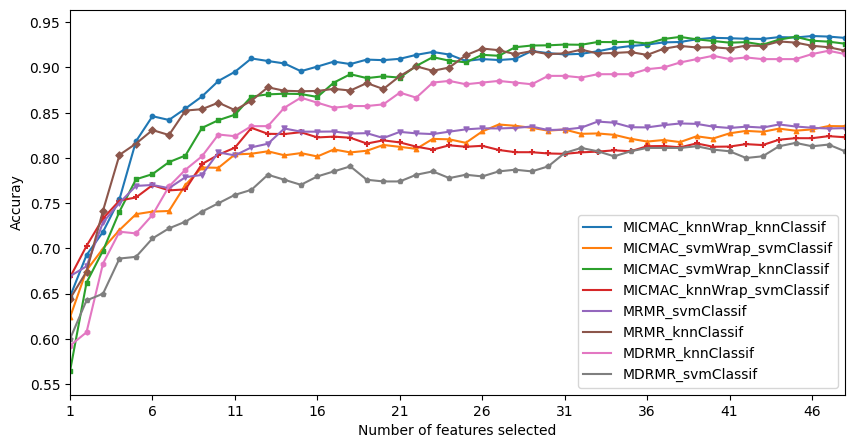

In [329]:
fig = plt.figure(figsize=(10, 5)) 
plt.plot(score_list_knnWrap_knnClassif, label='MICMAC_knnWrap_knnClassif')
#knnWrap_knnClassif_max_index = np.argmax(score_list_knnWrap_knnClassif)
#knnWrap_knnClassif_max_x = knnWrap_knnClassif_max_index 
#knnWrap_knnClassif_max_y = score_list_knnWrap_knnClassif[knnWrap_knnClassif_max_index ]
plt.scatter(np.arange(0,len(score_list_knnWrap_knnClassif)), score_list_knnWrap_knnClassif, marker='o',s=10)

plt.plot(score_list_svmWrap_svmClassif, label='MICMAC_svmWrap_svmClassif')
plt.scatter(np.arange(0,len(score_list_svmWrap_svmClassif)), score_list_svmWrap_svmClassif, marker='^',s=10)

plt.plot(score_list_svmWrap_knnClassif, label='MICMAC_svmWrap_knnClassif')
plt.scatter(np.arange(0,len(score_list_svmWrap_knnClassif)), score_list_svmWrap_knnClassif, marker='s',s=10)

plt.plot(score_list_knnWrap_svmClassif, label='MICMAC_knnWrap_svmClassif')
plt.scatter(np.arange(0,len(score_list_knnWrap_svmClassif)), score_list_knnWrap_svmClassif, marker='+',s=13)

plt.plot(mrmr_score_list_svmClassif, label='MRMR_svmClassif')
plt.scatter(np.arange(0,len(mrmr_score_list_svmClassif)), mrmr_score_list_svmClassif, marker='v',s=13)

plt.plot(mrmr_score_list_knnClassif, label='MRMR_knnClassif')
plt.scatter(np.arange(0,len(mrmr_score_list_knnClassif)), mrmr_score_list_knnClassif, marker='D',s=13)

plt.plot(mdrmr_score_list_knnClassif, label='MDRMR_knnClassif')
plt.scatter(np.arange(0,len(mdrmr_score_list_knnClassif)), mdrmr_score_list_knnClassif, marker='h',s=13)

plt.plot(mdrmr_score_list_svmClassif, label='MDRMR_svmClassif')
plt.scatter(np.arange(0,len(mdrmr_score_list_svmClassif)), mdrmr_score_list_svmClassif, marker='p',s=13)

plt.legend()
plt.xticks(np.arange(1, 49, 5))
plt.xlim(1, 48)
plt.xlabel('Number of features selected') 
plt.ylabel('Accuray') 
#plt.show()
plt.savefig('#feat.pdf', format='pdf')

### significance test

In [336]:
#knnWrap_knnClassif=50
#knnWrap_svmClassif=12
#svmWrap_knnClassif=38
#svmWrap_svmClassif=27
#MRMR_knnClassif=26
#MRMR_svmClassif=14

#ff=frequencyDict_svm[0:38]
ff=mdrmr_frequencyDict[0:47]
clf_svm=knn
#clf_svm=SVC(kernel='rbf',probability=True, random_state=42)
pred_dbs_T_dif_alpha={}
prob_alpha={}
Ac=[]

for s in range(0,10):
    clf_svm.fit(Xtv[s][:,ff ],Ytv[s])#alpha_feat[0:10]
    pred_dbs_T_dif_alpha[s]= clf_svm.predict(Xtest[s][:,ff])#alpha_feat[0:10] 
    ac=(accuracy_score(pred_dbs_T_dif_alpha[s],Ytest[s]))
    prob_alpha[s] = clf_svm.predict_proba(Xtest[s][:,ff]) #alpha_feat[0:10]
    print(ac)
    Ac.append(ac)    
print('final acc',sum(Ac)/len(Ac))
final_score_delta=sum(Ac)/len(Ac)

#acc_svmWarp_knnClassif=Ac
acc_MDRMR_knnClassif=Ac
statistics.stdev(Ac)

0.9074074074074074
0.9629629629629629
0.9074074074074074
0.9259259259259259
0.8888888888888888
0.8703703703703703
0.9814814814814815
0.8888888888888888
0.8518518518518519
0.9074074074074074
final acc 0.9092592592592592


0.039477227050171565

In [273]:
import statistics
for i in [acc_knnWarp_knnClassif,acc_knnWarp_svmClassif,acc_svmWarp_knnClassif,acc_svmWarp_svmClassif,
         acc_MRMR_svmClassif,acc_MRMR_knnClassif]:
    print('mean',np.sum(i)/len(i), ' std', statistics.stdev(i))

mean 0.9018518518518519  std 0.03908923505922854
mean 0.8129629629629628  std 0.03849991636916709
mean 0.8592592592592592  std 0.05105203241514897
mean 0.812962962962963  std 0.033184395199297806
mean 0.8092592592592593  std 0.051682557256628354
mean 0.8666666666666666  std 0.04999618946004097


In [275]:
from scipy.stats import f_oneway
f_value, p_value = f_oneway(acc_knnWarp_knnClassif, acc_knnWarp_svmClassif, acc_svmWarp_knnClassif, acc_svmWarp_svmClassif, acc_MRMR_svmClassif, acc_MRMR_knnClassif)

# Check significance level
alpha = 0.05
if p_value < alpha:
    print("The lists are significantly different (reject null hypothesis)")
else:
    print("The lists are not significantly different (fail to reject null hypothesis)")

The lists are significantly different (reject null hypothesis)


In [280]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#all_data = acc_knnWarp_knnClassif + acc_knnWarp_svmClassif + acc_svmWarp_knnClassif + acc_svmWarp_svmClassif + acc_MRMR_svmClassif + acc_MRMR_knnClassif
all_data = acc_knnWarp_knnClassif + acc_svmWarp_knnClassif + acc_MRMR_knnClassif
group_labels = ['knnWrap_knnClassif (D=12)'] * len(acc_knnWarp_knnClassif) +  ['svmWrap_knnClassif (D=38)'] * len(acc_svmWarp_knnClassif) + ['MRMR_knnClassif (D=26)'] * len(acc_MRMR_knnClassif)

tukey_result = pairwise_tukeyhsd(all_data, group_labels)
print(tukey_result.summary())


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
          group1                    group2          meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------------
   MRMR_knnClassif (D=26) knnWrap_knnClassif (D=12)  -0.0148 0.6781 -0.0582 0.0286  False
   MRMR_knnClassif (D=26) svmWrap_knnClassif (D=38)  -0.0037 0.9757 -0.0471 0.0397  False
knnWrap_knnClassif (D=12) svmWrap_knnClassif (D=38)   0.0111 0.8025 -0.0323 0.0545  False
-----------------------------------------------------------------------------------------


##### 12 KNN wrapper + KNN classif features 

In [192]:
frequencyDict_knn[0:12]
#([5418, 5390, 4847, 4517, 4159, 5468, 5309, 7511, 5593, 1330, 4231,976])

array([5418, 5390, 4847, 4517, 4159, 5468, 5309, 7511, 5593, 1330, 4231,
        976])

In [196]:
os.chdir('/home/jupy/SourceAnalysis')
#coordinates=pd.read_csv('allBA_eLORETA-ROI.csv').values[:,0:3]
#coordinates.shape
coordinates=np.loadtxt('allBA_eLORETA-ROIcentroids.txt')

ROI85=[ -8.785714 ,  28.64286  ,  21.28572  ,  53.       ]
ROI86=ROI85
ROI87=   [  7.529412 ,  29.58824  ,  20.41176  ,  54.       ]
ROI88=ROI87

coordinates=np.vstack([coordinates,ROI85,ROI86,ROI87,ROI88])[:,0:3]
coordinates.shape

(88, 3)

coherence btw channel pair:  61 50
coherence btw channel pair:  61 22
coherence btw channel pair:  55 7
coherence btw channel pair:  51 29
coherence btw channel pair:  47 23
coherence btw channel pair:  62 12
coherence btw channel pair:  60 29
coherence btw channel pair:  85 31
coherence btw channel pair:  63 49
coherence btw channel pair:  15 10
coherence btw channel pair:  48 7
coherence btw channel pair:  11 8


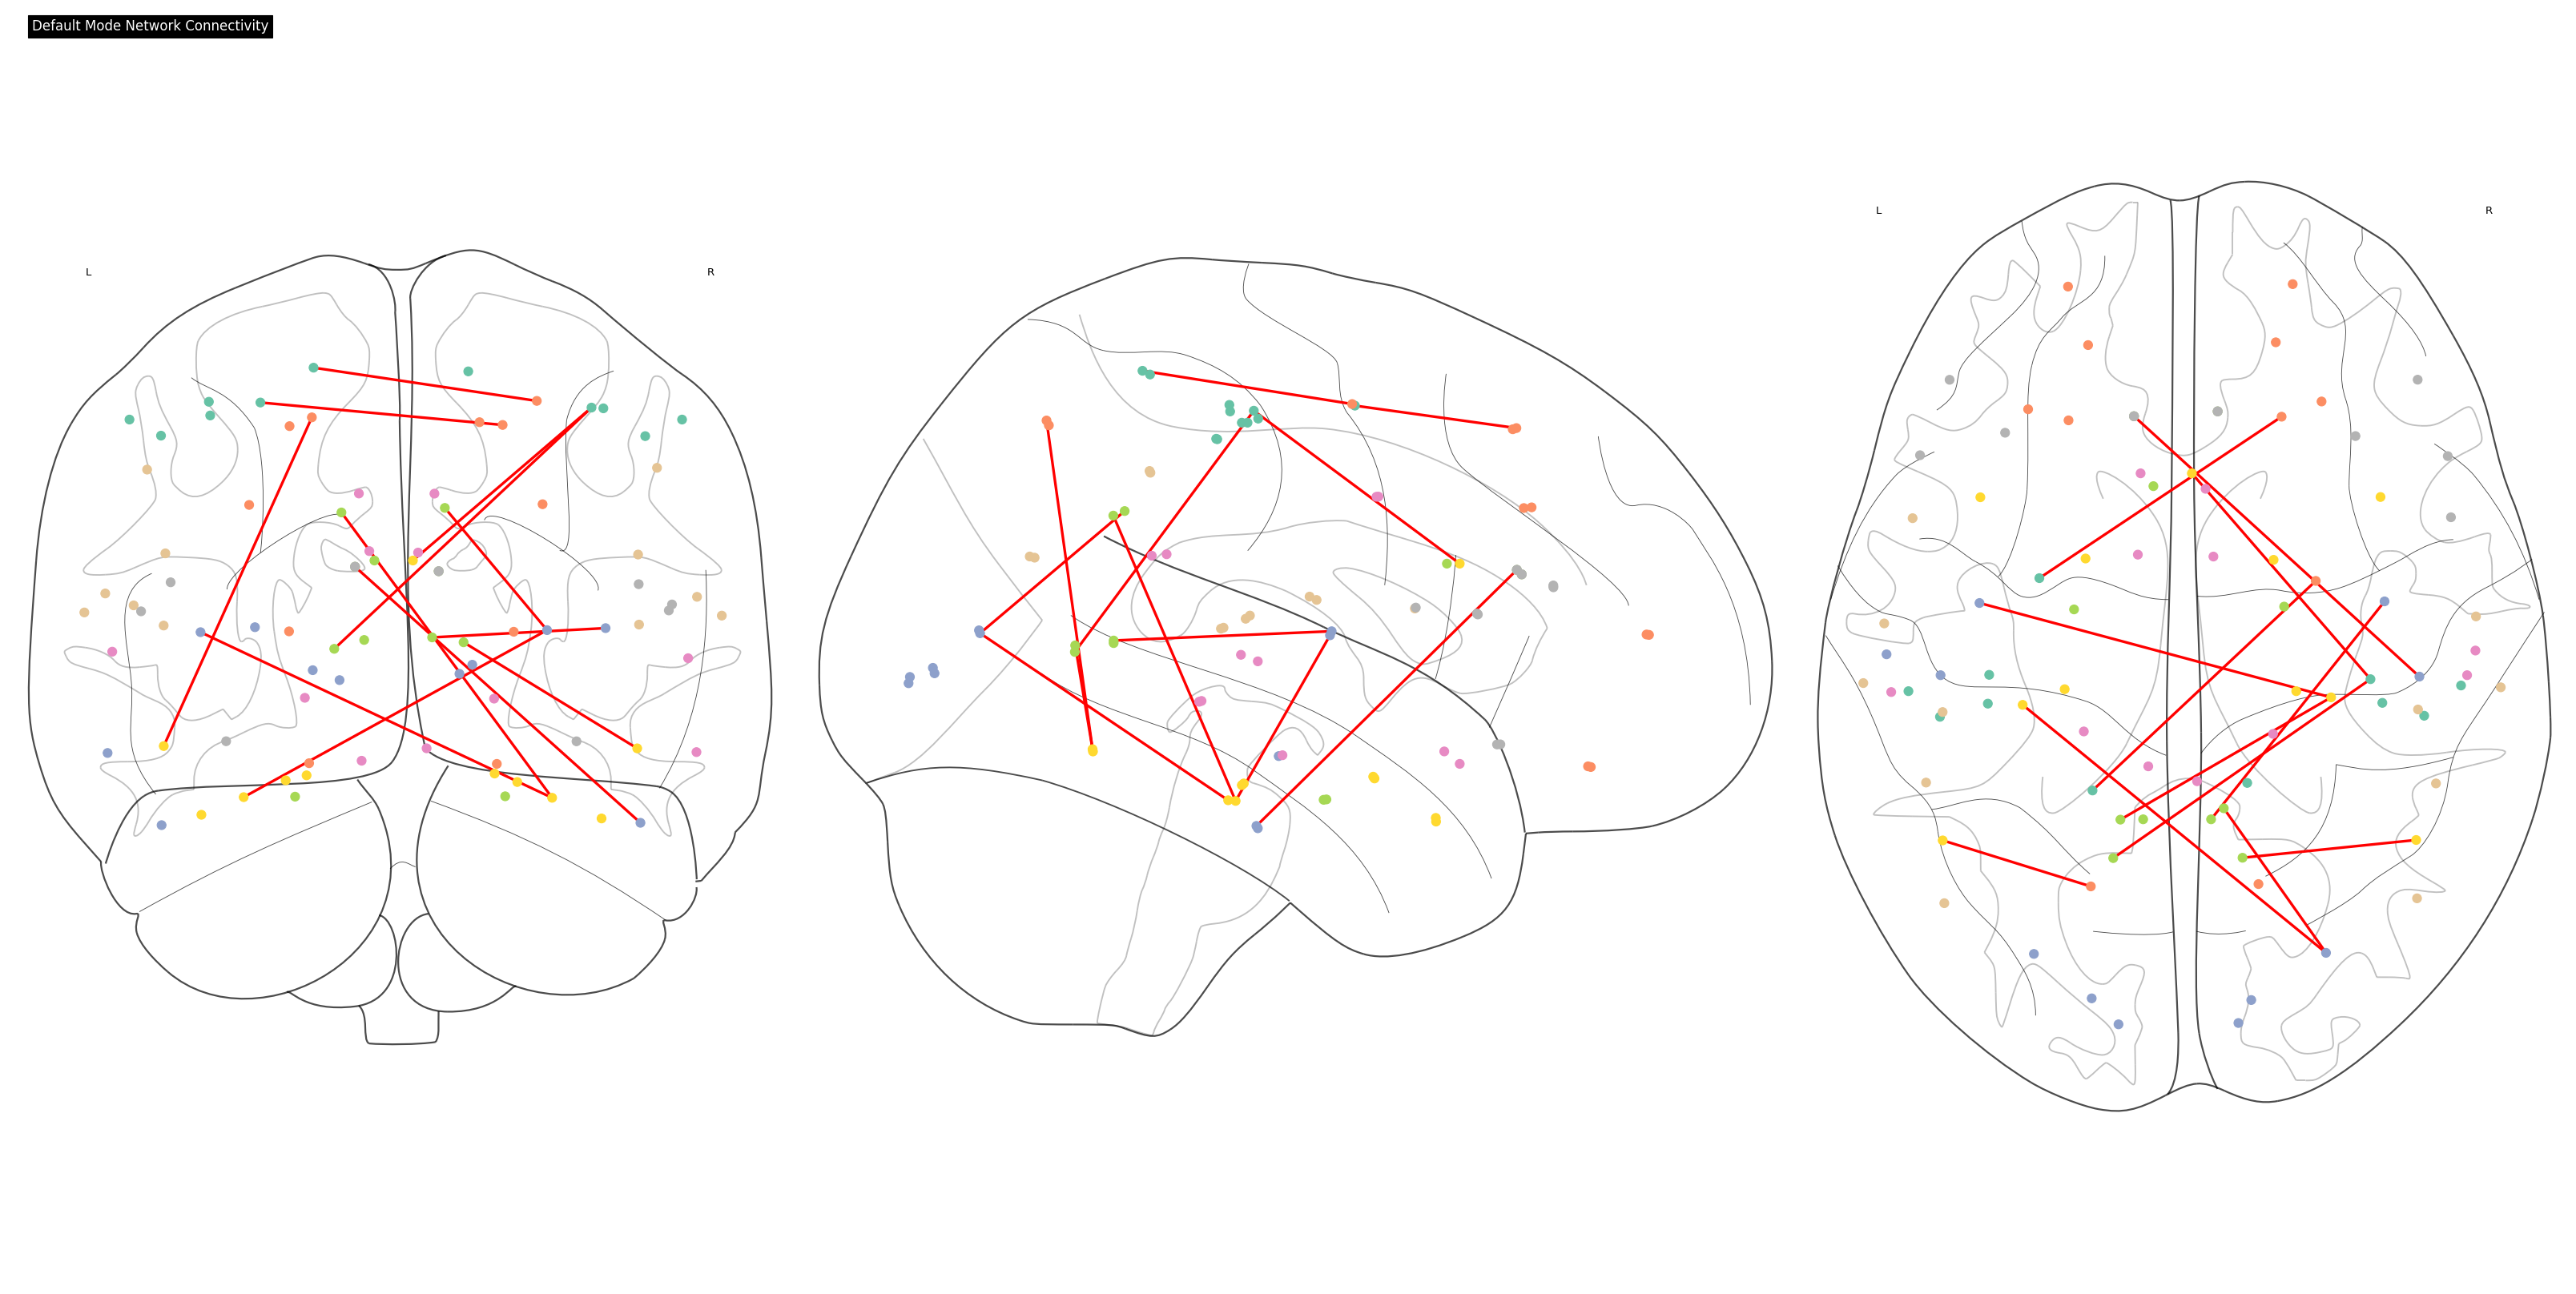

In [221]:
sensor= np.arange(0,88)#.astype(str)

nodes1=np.zeros([2])
nodes2=np.zeros([2])


for i in frequencyDict_knn[0:12]:
    chanel1=int((i)//88)
    name_chan1=sensor[chanel1]
    chanel2=int((i)%88)
    name_chan2=sensor[chanel2]
    
    nodes1=np.vstack([nodes1,np.array([name_chan1,name_chan2])])
    nodes2=np.vstack([nodes2,np.array([name_chan2,name_chan1])])
    print('coherence btw channel pair: ', name_chan1,name_chan2)
nodes1=nodes1[1:,:].astype(int)
nodes2=nodes2[1:,:].astype(int)

nodes_ar=np.zeros([88,88])
for i in range(0,nodes1.shape[0]):
    nodes_ar[nodes1[i][0],nodes1[i][1]]=1
    nodes_ar[nodes2[i][0],nodes2[i][1]]=1

import nilearn
from nilearn import plotting
from matplotlib.pyplot import figure
sa=figure(figsize = (40, 20), dpi = 80)
os.chdir('/home/jupy')
plotting.plot_connectome(nodes_ar, coordinates,node_size=100,figure=sa,
                         title="Default Mode Network Connectivity" )


In [199]:
clf_svm=rf
feature_importance={}
for s in range(0,10):
    clf_svm.fit(Xtv[s][:,frequencyDict_knn[0:12] ],Ytv[s])
    feature_importance[s] = clf_svm.feature_importances_

shap_value=np.zeros([len(frequencyDict_knn[0:12])])
for s in range(0,10):
    shap_value=shap_value+feature_importance[s]
shap_value=shap_value/10
shap_value

array([0.06764257, 0.08556598, 0.11736509, 0.10846023, 0.09447631,
       0.06584483, 0.06181283, 0.05233192, 0.07173977, 0.10481595,
       0.08119268, 0.08875186])

##### tuning gamma

In [22]:
cv = StratifiedKFold(n_splits=10,  shuffle=False)
tune_gamma_result=[]
for gamma in np.arange(210.1,230.1,1):
    re=[]
    for s in range(0,10):
        clf_svm=SVC(kernel='rbf',probability=True, random_state=42,gamma=gamma) 
        AC=cross_val_score(clf_svm, Xtv[s][:,ff], Ytv[s], scoring='accuracy', cv=cv, n_jobs=-1)
        re.append(sum(AC)/len(AC))

    tune_gamma_result.append (sum(re)/len(re)) 
    print('gamma is', gamma, 'acc is',sum(re)/len(re))  

gamma is 210.1 acc is 0.8271215986394556
gamma is 211.1 acc is 0.8269175170068026
gamma is 212.1 acc is 0.8267134353741497
gamma is 213.1 acc is 0.8269175170068028
gamma is 214.1 acc is 0.8271215986394557
gamma is 215.1 acc is 0.8271215986394557
gamma is 216.1 acc is 0.8269132653061224
gamma is 217.1 acc is 0.8269132653061224
gamma is 218.1 acc is 0.8269132653061224
gamma is 219.1 acc is 0.8269132653061224
gamma is 220.1 acc is 0.8271215986394559
gamma is 221.1 acc is 0.827125850340136
gamma is 222.1 acc is 0.8267134353741497
gamma is 223.1 acc is 0.8267134353741497
gamma is 224.1 acc is 0.8265093537414966
gamma is 225.1 acc is 0.8267134353741497
gamma is 226.1 acc is 0.8265136054421769
gamma is 227.1 acc is 0.8263095238095239
gamma is 228.1 acc is 0.8263095238095239
gamma is 229.1 acc is 0.8263095238095239


In [103]:

state_numb=1
t0=connectivity[band][state_numb*60:(state_numb+1)*60 , :]

def classif_each_time(t0):
    avg_acc=0
    for i in range(0,6): # 6-fold CV
        l_test_id=np.arange(i*5,(i+1)*5)
        l_train_id = [x for x in np.arange(0,30) if x not in l_test_id]
        ob_test_id=np.arange(30+i*5,30+(i+1)*5)
        ob_train_id = [x for x in np.arange(30,60) if x not in ob_test_id]

        t0_l_train=t0[l_train_id,:][:,alpha_features]
        t0_l_test=t0[l_test_id,:][:,alpha_features]
        t0_ob_train=t0[ob_train_id,:][:,alpha_features]
        t0_ob_test=t0[ob_test_id,:][:,alpha_features]
        t0_train=np.vstack([t0_l_train,t0_ob_train])
        t0_train=pd.concat([pd.DataFrame(t0_train), pd.Series( np.hstack([np.zeros([25,]),np.ones([25,])]) )  ],axis=1)
        t0_test=np.vstack([t0_l_test,t0_ob_test])
        shuffled_t0_train = t0_train.sample(frac=1, random_state=42)  # Set a random_state for reproducibility
        shuffled_t0_train.reset_index(drop=True, inplace=True)

        rf.fit(np.array(shuffled_t0_train)[:,:-1],np.array(shuffled_t0_train)[:,-1])
        avg_acc=avg_acc+(accuracy_score(rf.predict(t0_test), [0,0,0,0,0,1,1,1,1,1]))
    avg_acc=avg_acc/6
    return avg_acc

In [104]:
alpha_features=([5418, 5390, 4847, 4517, 4159, 5468, 5309, 7511, 5593, 1330, 4231,976])
timestates=np.array([0,15,30,45,60,90,120,180,240]).astype(str)

In [105]:
for state_numb in range(0,9):
    t0=connectivity[band][state_numb*60:(state_numb+1)*60 , :]
    print(timestates[state_numb],' ',classif_each_time(t0))

0   0.5833333333333334
15   0.6333333333333334
30   0.55
45   0.65
60   0.5666666666666668
90   0.5333333333333333
120   0.5833333333333334
180   0.5833333333333334
240   0.5666666666666667


In [143]:
from sklearn.manifold import TSNE
def tsne_plot(tsne_input,state_numb):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_result = tsne.fit_transform(tsne_input)
    data_1= tsne_result[0:30,:]
    data_2 = tsne_result[30:60,:]
    # Create a scatter plot with different colors for each group
    plt.scatter(data_1[:, 0], data_1[:, 1], c='b', label='Lean', marker='o',alpha=0.3)
    plt.scatter(data_2[:, 0], data_2[:, 1], c='r', label='Obese', marker='s',alpha=0.3)

    for p,corl in zip([4,12,26],['crimson','#800000','#FF6347']):
        plt.scatter(data_1[p, 0], data_1[p, 1], c=corl,marker='+',s=100)
        
    for pp,corl in zip([6,15,29],['navy','#008080','#6A5ACD']):
        plt.scatter(data_2[pp, 0], data_2[pp, 1], c=corl,marker='x',s=100)
    
    
    plt.title(f'{timestates[state_numb]}min')
    plt.legend()
    plt.show()

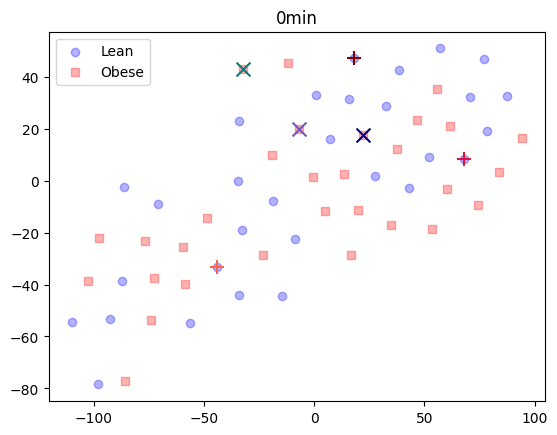

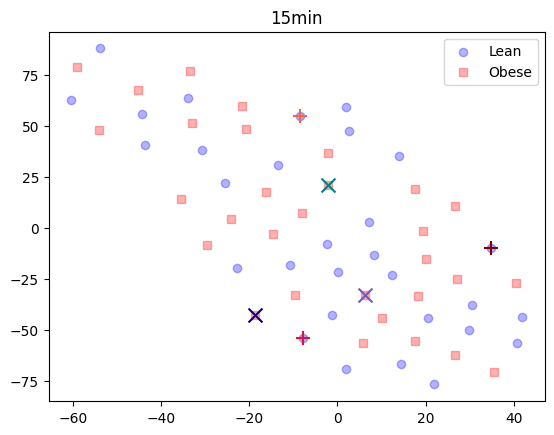

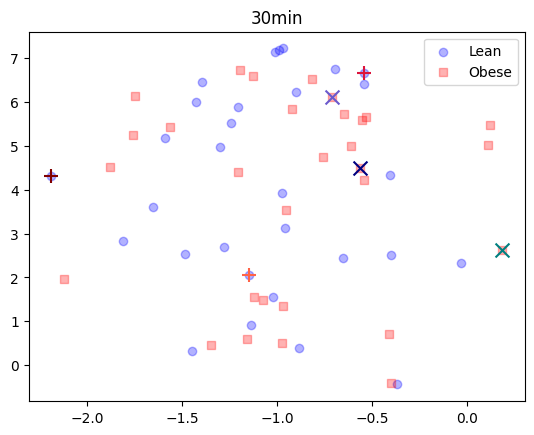

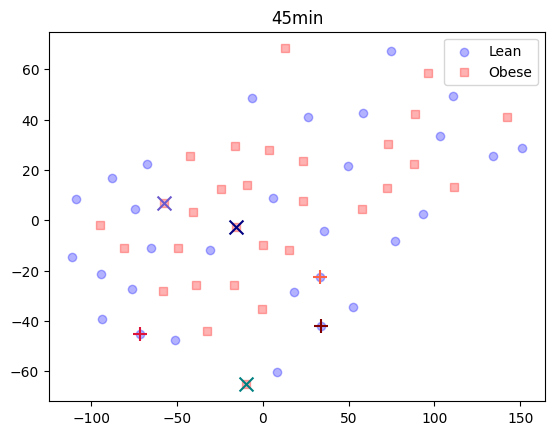

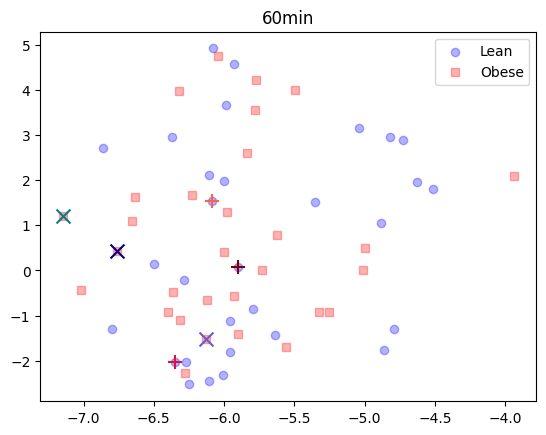

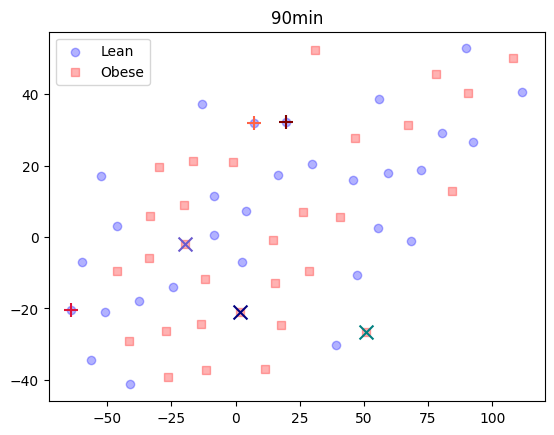

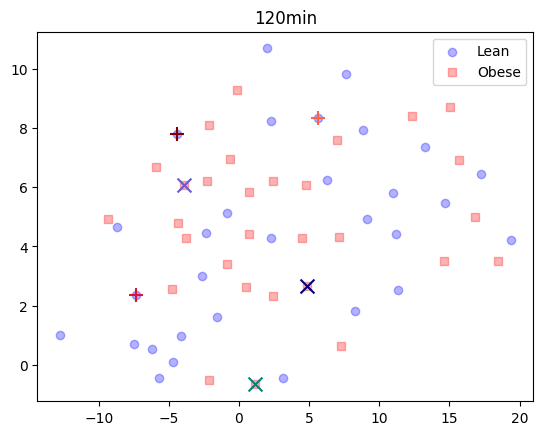

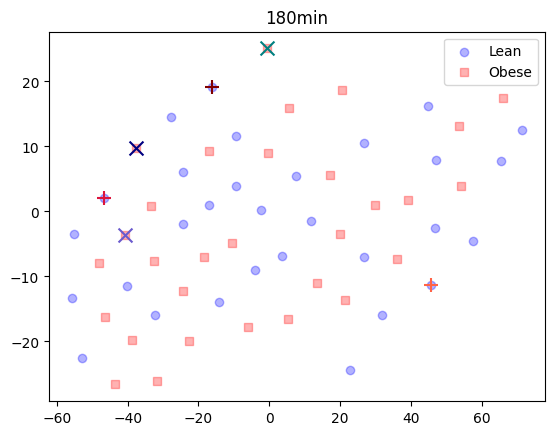

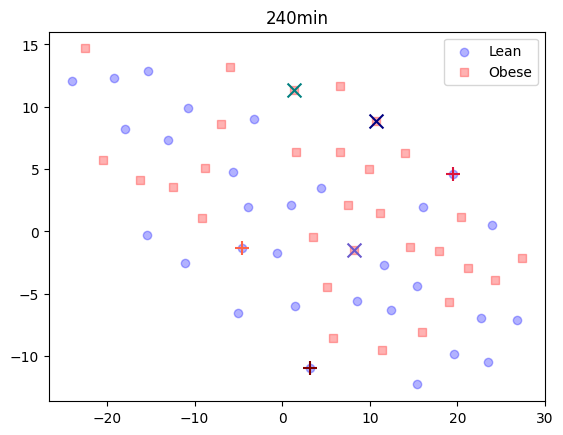

In [144]:
for state_numb in range(0,9):
    #state_numb=3 
    tsne_input=connectivity[band][state_numb*60:(state_numb+1)*60 , :][:,alpha_features]
    tsne_plot(tsne_input,state_numb)

88.0